In [1]:
import numpy as np
import keras

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

import seaborn as sns

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

from tqdm.notebook import tqdm

from scipy import stats

from sklearn import datasets

import sys 
sys.path.append("../")
from KDG import KDG

import openml

# Experiment Parameters

In [2]:
widths = [8, 8]
num_trials = 5

# Data Generation

# Construct & Train Network

In [3]:
def construct_network(X, y, widths):
    network = keras.Sequential()
    network.add(keras.layers.Dense(widths[0], input_shape = np.shape(X)[1:], activation = 'relu'))
    for i in range(1, len(widths)):
        network.add(keras.layers.Dense(widths[i], activation = 'relu'))
    network.add(keras.layers.Dense(len(np.unique(y)), activation = 'sigmoid'))
    network.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(1e-3))
    network.fit(
      X, 
      keras.utils.to_categorical(y), 
      epochs = 30, 
      verbose = False,
      batch_size = int(2 ** (np.log(len(X)) / np.log(5) + 2.2))
    )

    return network

## Keurnal Networks

In [4]:
def train_AKN(X, y):
    X_transform, y_transform = X, y
    network = construct_network(X_transform, y_transform, widths)

    polytope_memberships = []
    last_activations = X
    
    for layer_id in range(len(network.layers)):
        weights, bias = network.layers[layer_id].get_weights()
        preactivation = np.matmul(last_activations, weights) + bias
        if layer_id == len(widths) - 1:
            binary_preactivation = (preactivation > 0.5).astype('int')
        else:
            binary_preactivation = (preactivation > 0).astype('int')
        polytope_memberships.append(binary_preactivation)
        last_activations = preactivation * binary_preactivation
    polytope_memberships = [np.tensordot(np.concatenate(polytope_memberships, axis = 1), 2 ** np.arange(0, np.shape(np.concatenate(polytope_memberships, axis = 1))[1]), axes = 1)]

    return KDG().fit(X, y, polytope_memberships)

In [ ]:
def get_network_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n), replace = False)
    X, y = X[random_indices], y[random_indices]
    network = construct_network(X, y, widths)
    return network.predict_proba(X_test)
    

def get_KDE_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n), replace = False)
    X, y = X[random_indices], y[random_indices]
    kdg = train_AKN(X, y)
    y_proba_unnormalized = kdg.predict_proba(X_test)

    y_proba = y_proba_unnormalized.copy()
    for y_val in range(np.shape(y_proba)[1]):
        y_proba[:, y_val] /= np.sum(y_proba_unnormalized, axis = 1)
    
    return y_proba

In [ ]:
def get_ece(predicted_posterior, y):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 40
    eces_across_y_vals = []
    for y_val in np.unique(y):
        for i in range(num_bins):
            prop = i*1./num_bins
            inds = np.where((predicted_posterior[:, y_val] >= prop) & (predicted_posterior[:, y_val] <= prop+1./num_bins))[0]
            amts.append(len(inds))
            if len(inds) > 0:
                hists.append(len(np.where(y[inds] == y_val)[0])*1./len(inds))
                hists_hat.append(np.mean(predicted_posterior[inds, y_val]))
            else:
                hists.append(prop)
                hists_hat.append(prop + 0.5/num_bins)
        eces_across_y_vals.append(np.dot(np.abs(np.array(hists) - np.array(hists_hat)), amts) / np.sum(amts))
    return np.mean(eces_across_y_vals)

In [ ]:
def get_brier(predicted_posterior, y):
    brier_across_y_vals = []
    for y_val in np.unique(y):
        brier_across_y_vals.append(np.nanmean(np.abs(predicted_posterior[:, y_val] - (y == y_val).astype('int'))))
    return np.mean(brier_across_y_vals)

Instructions for updating:
Please use `model.predict()` instead.


Instructions for updating:
Please use `model.predict()` instead.


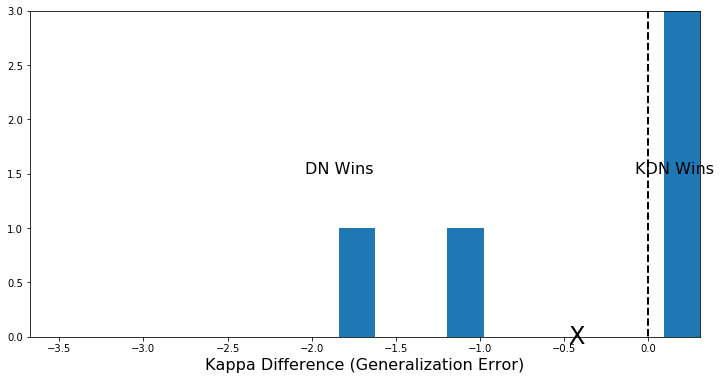

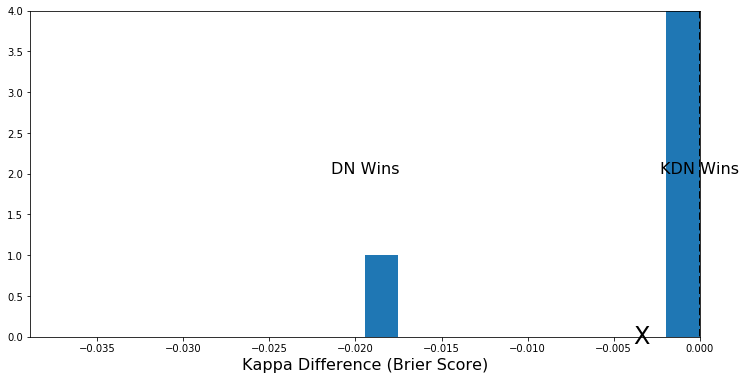

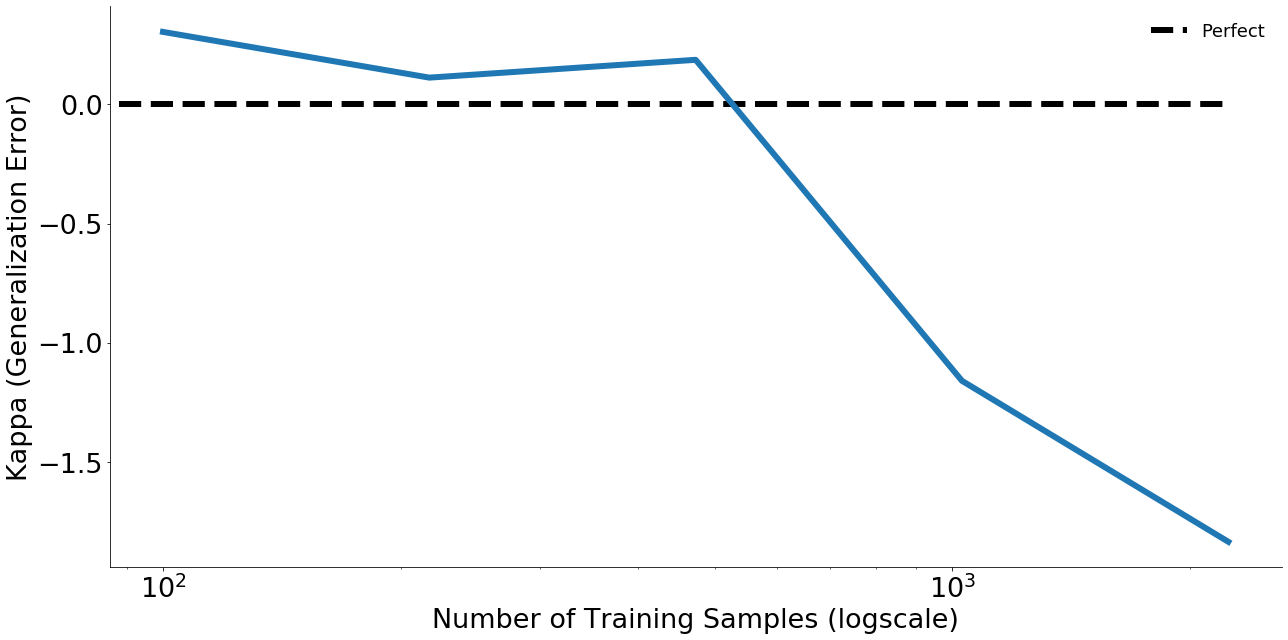

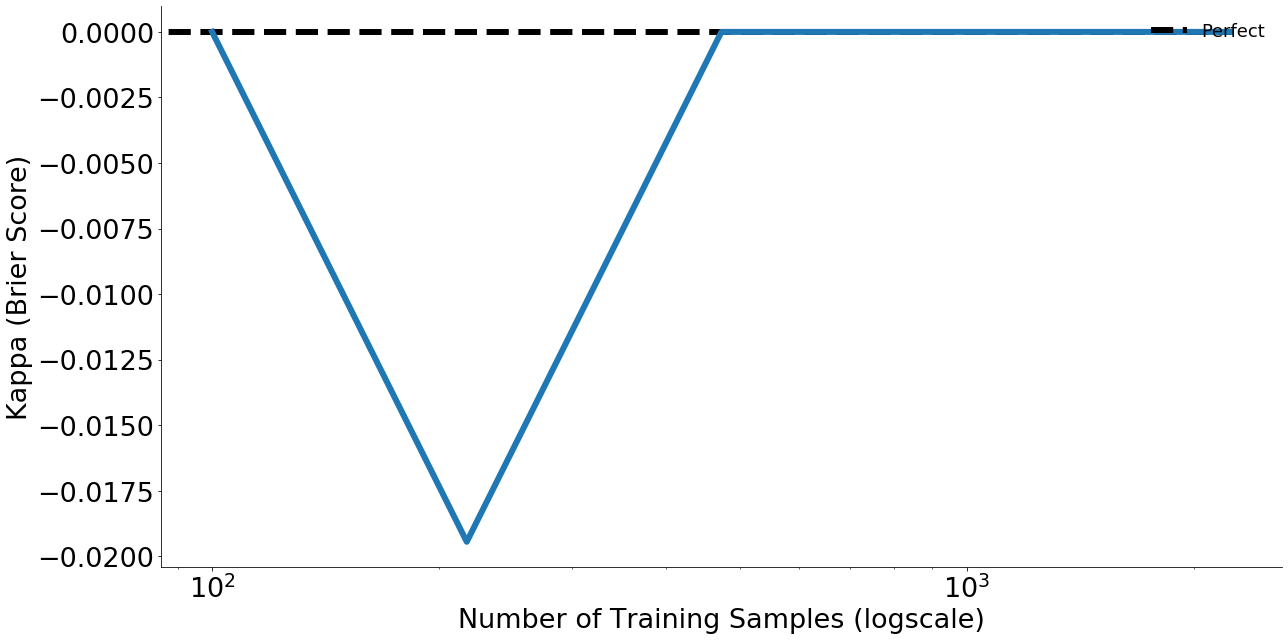

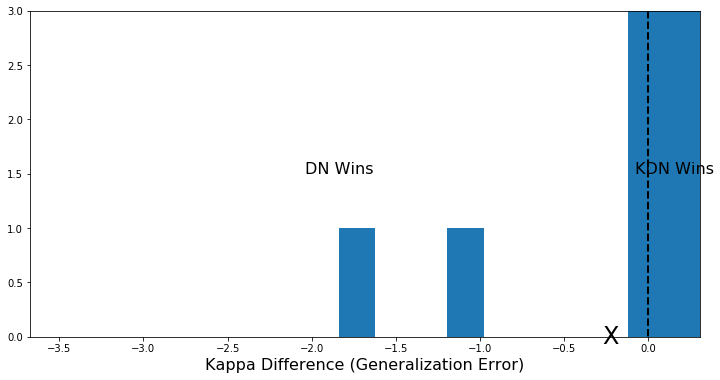

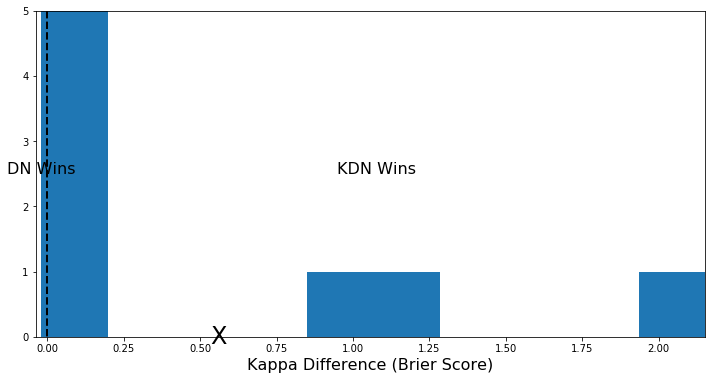

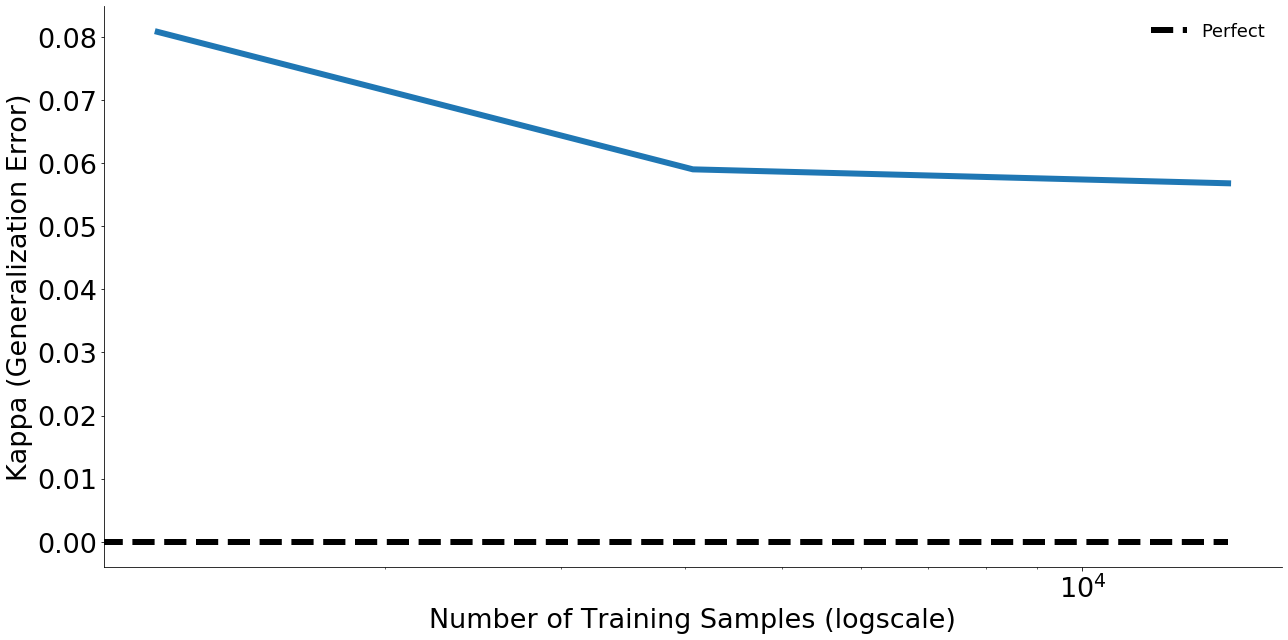

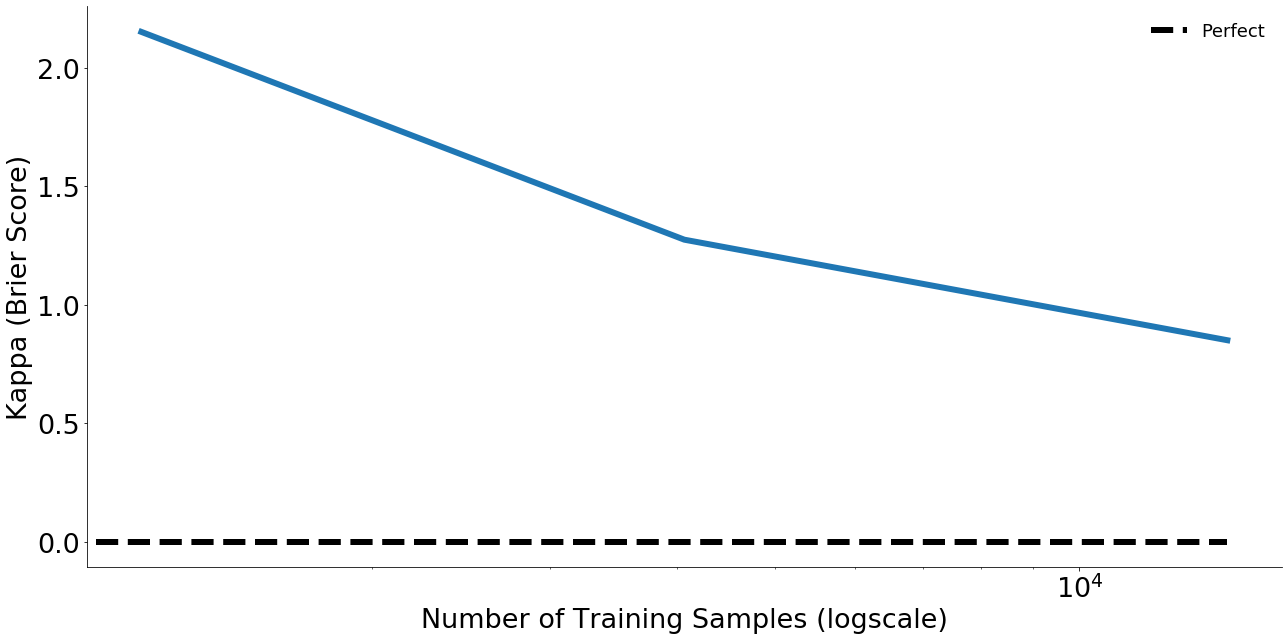

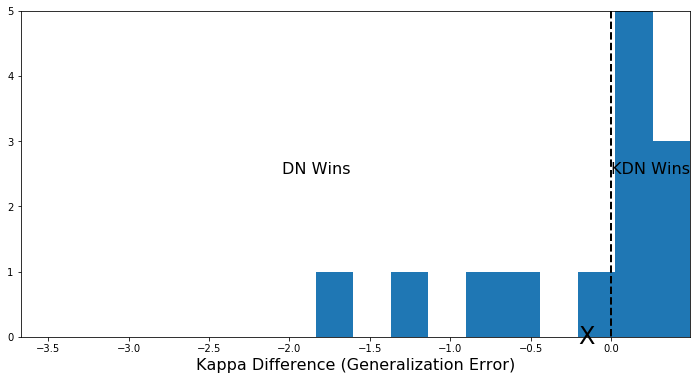

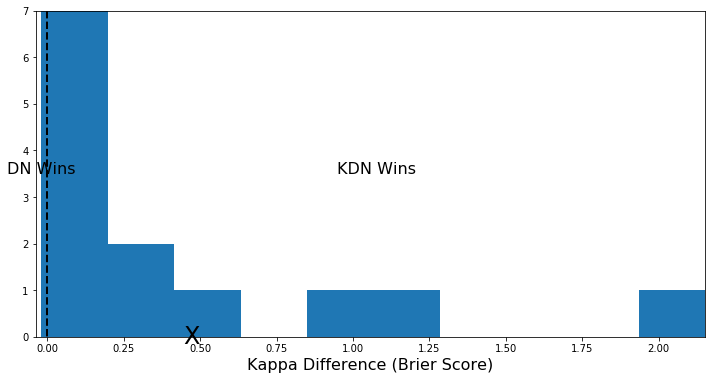

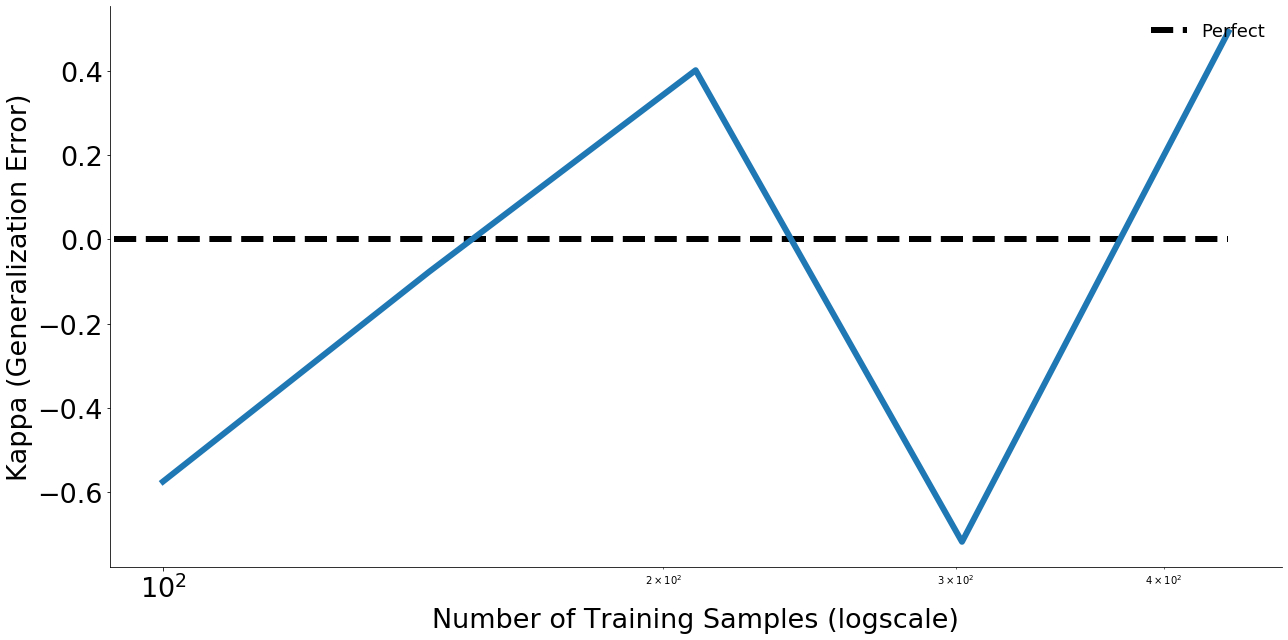

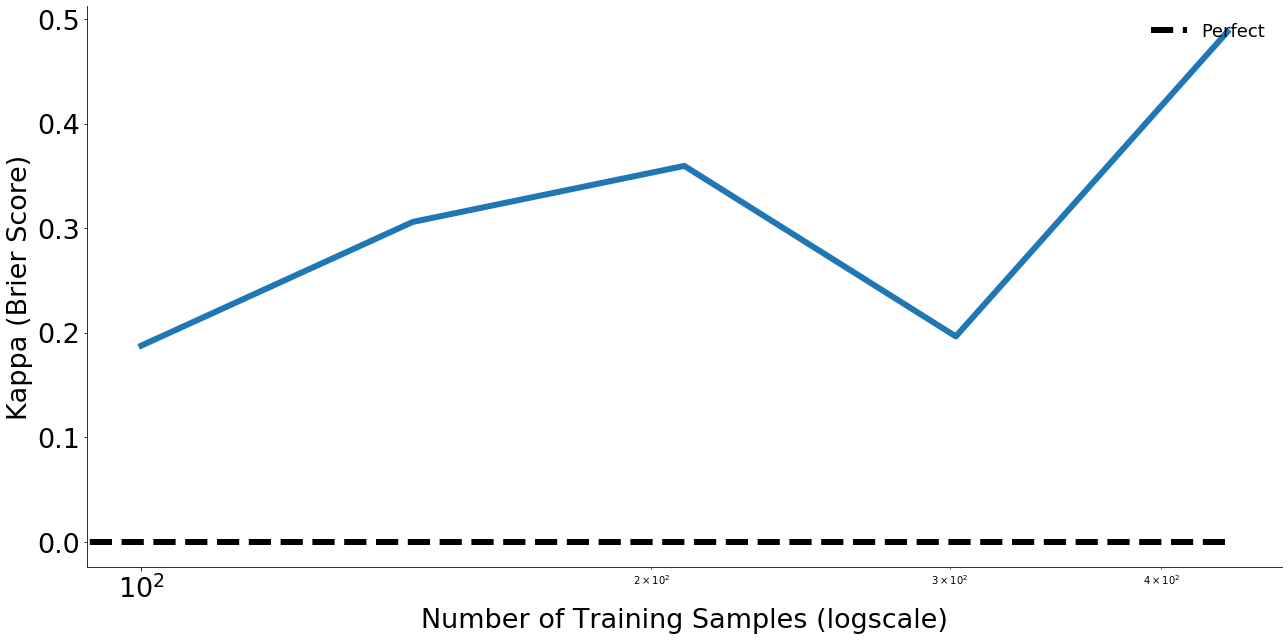

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


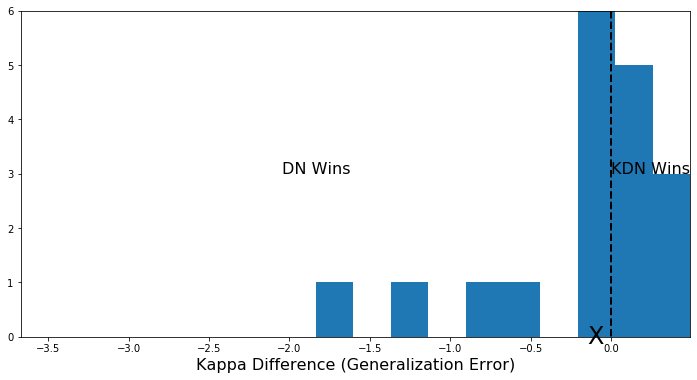

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


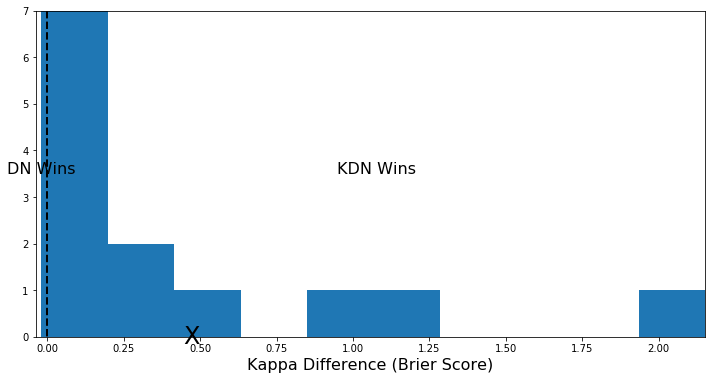

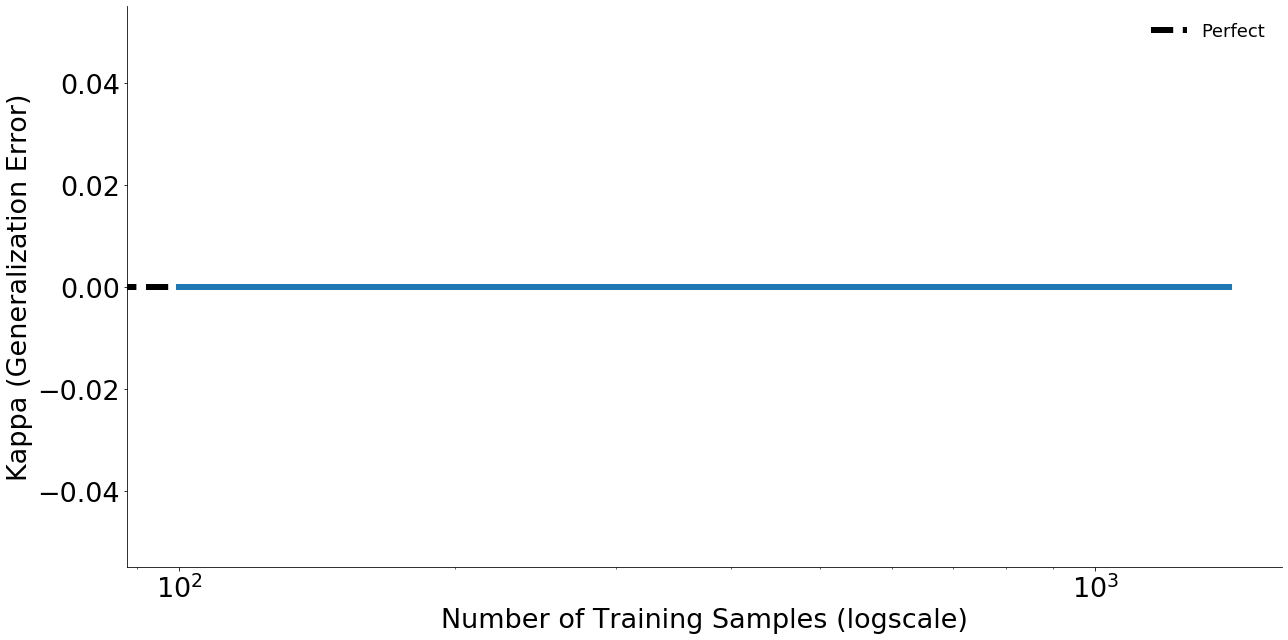

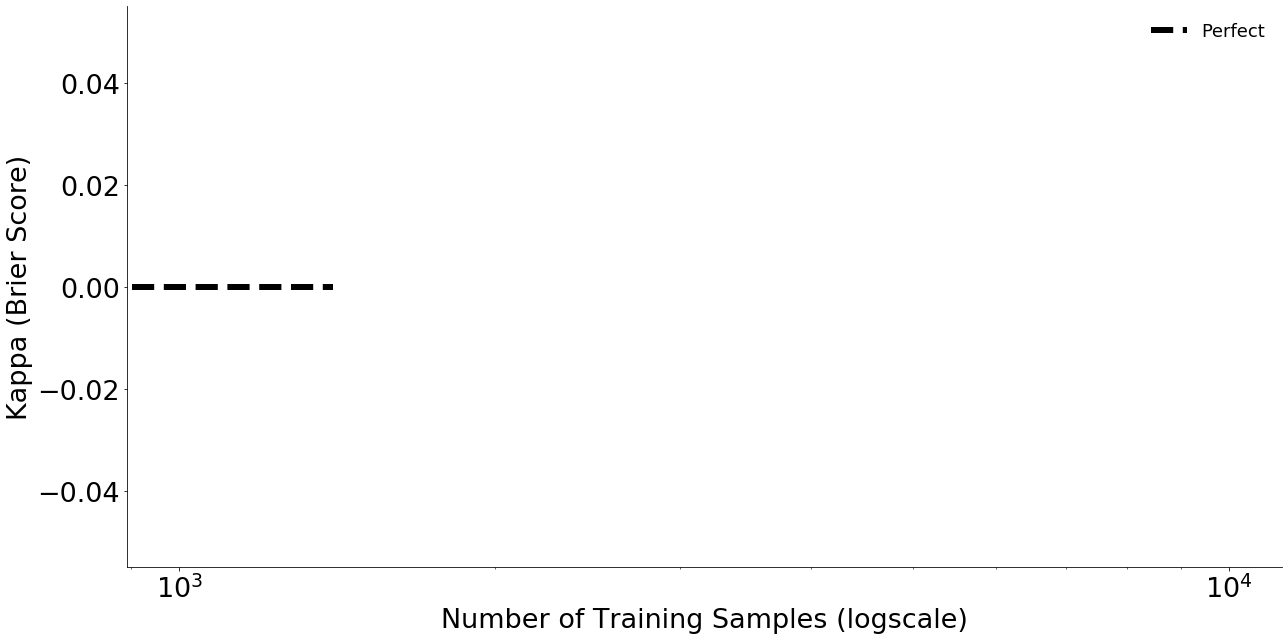

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


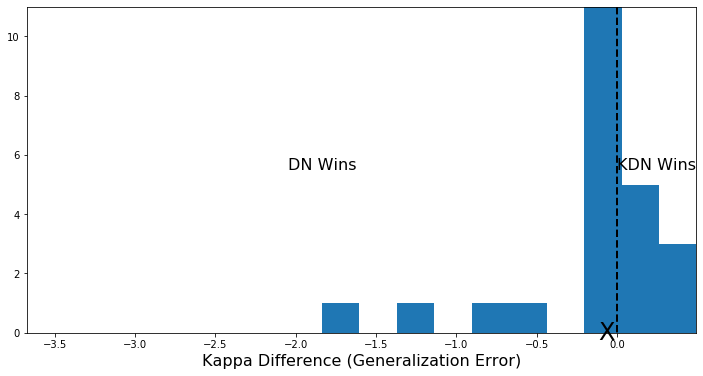

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


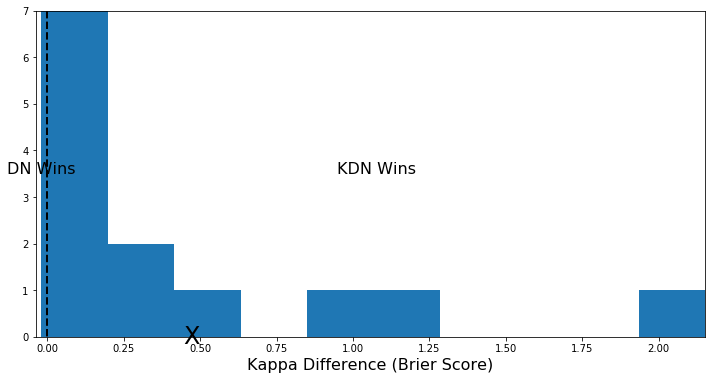

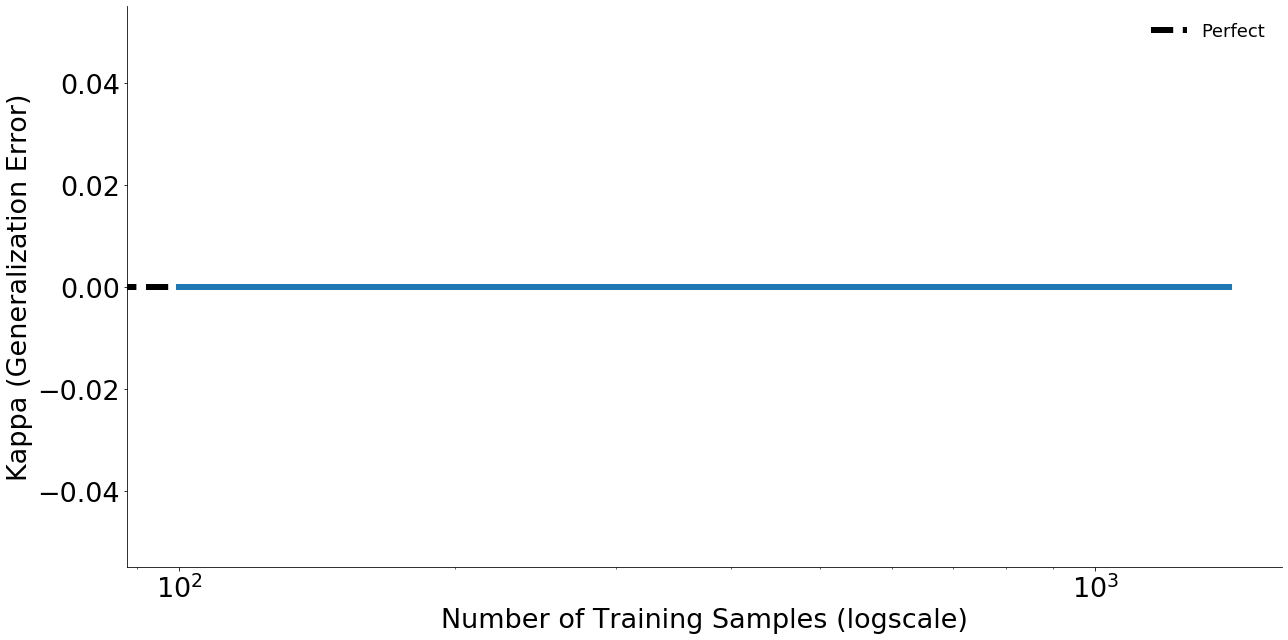

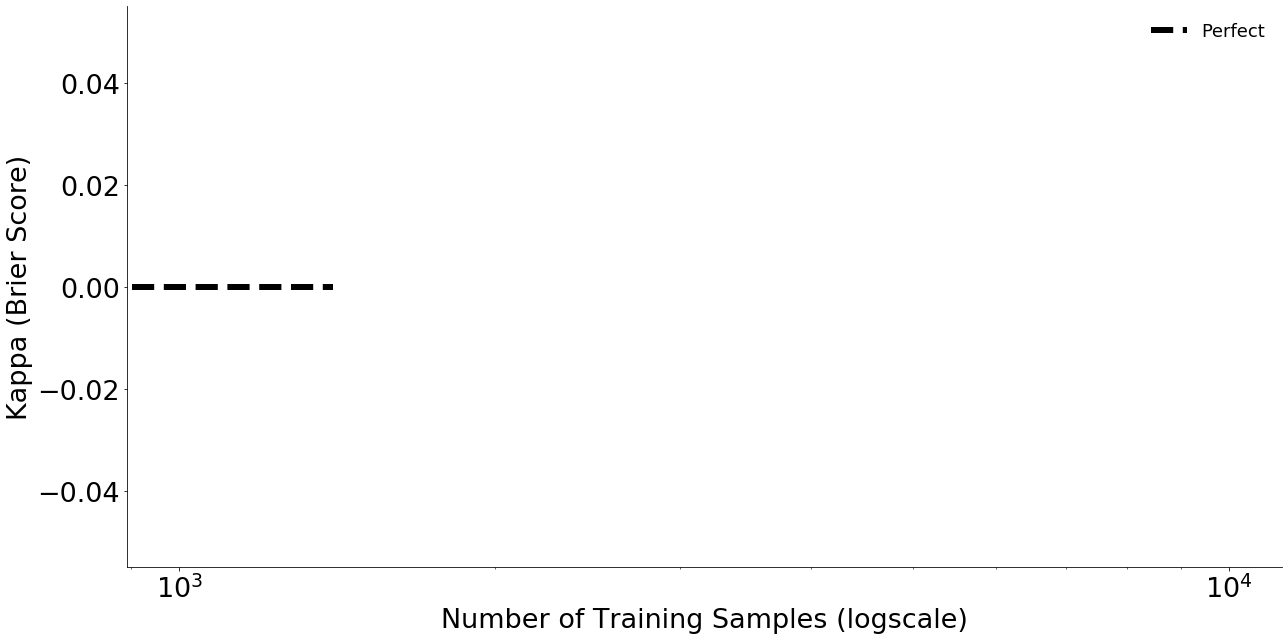

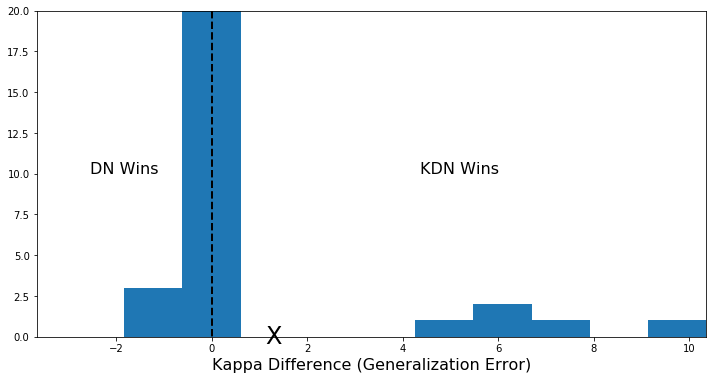

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


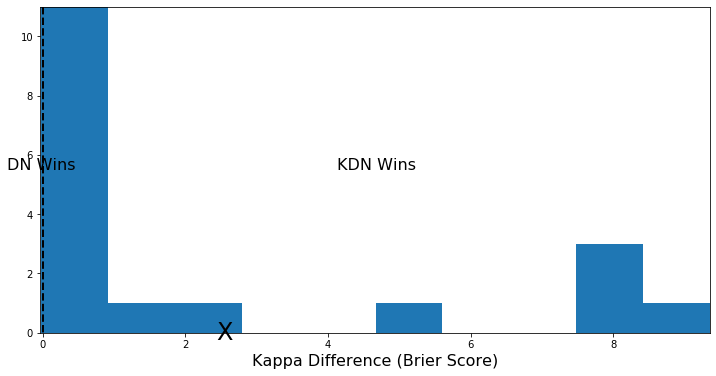

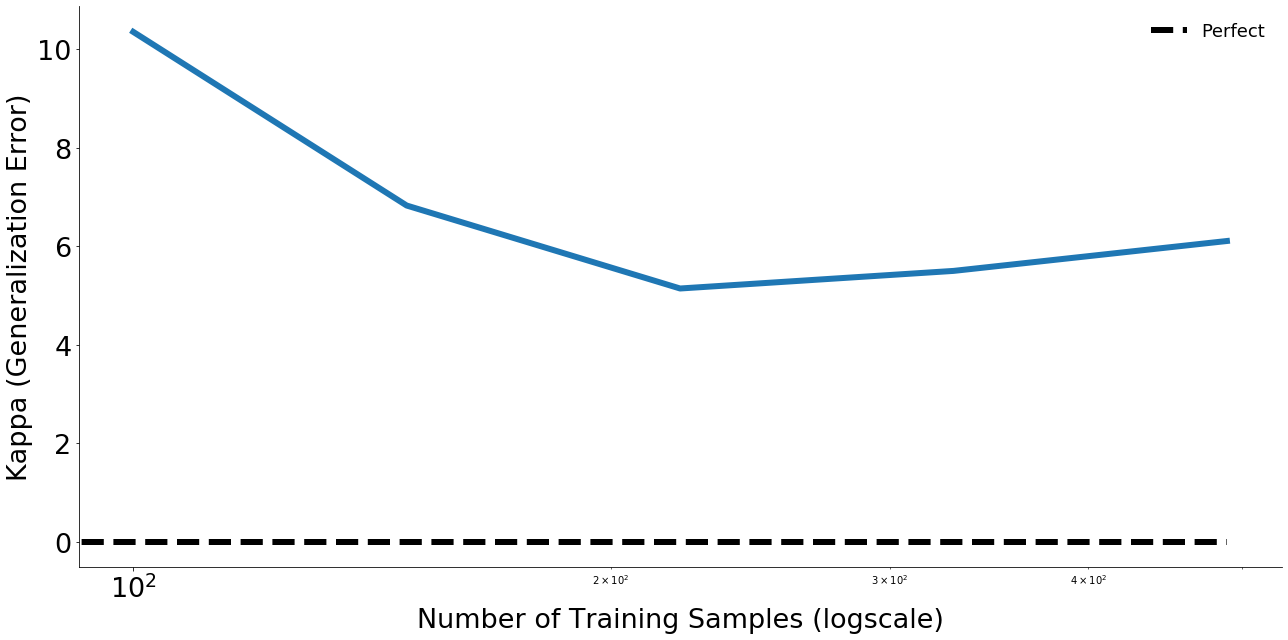

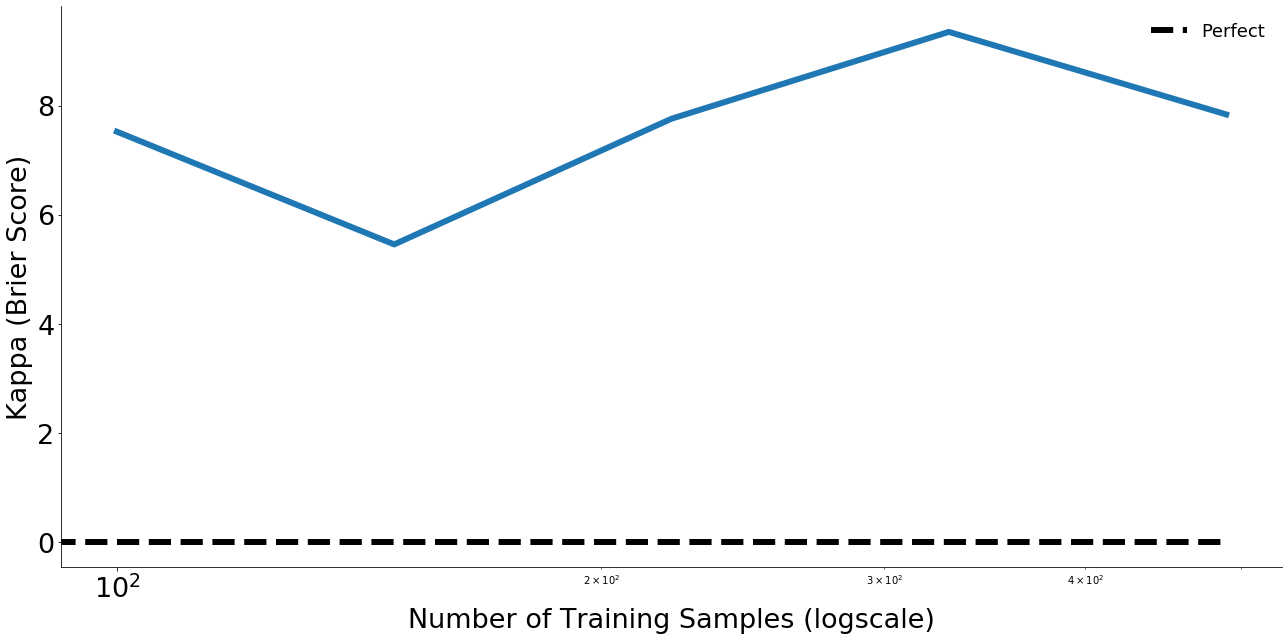

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


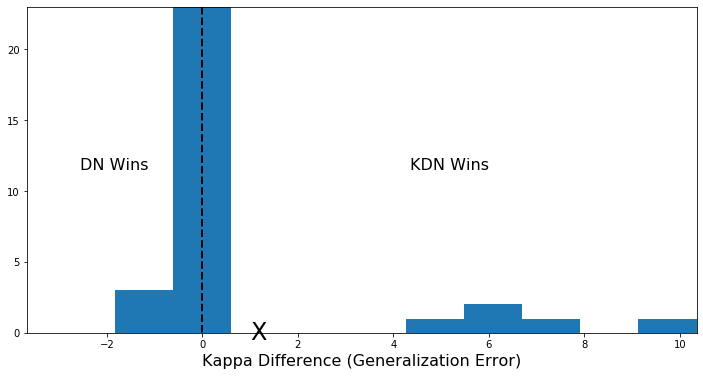

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


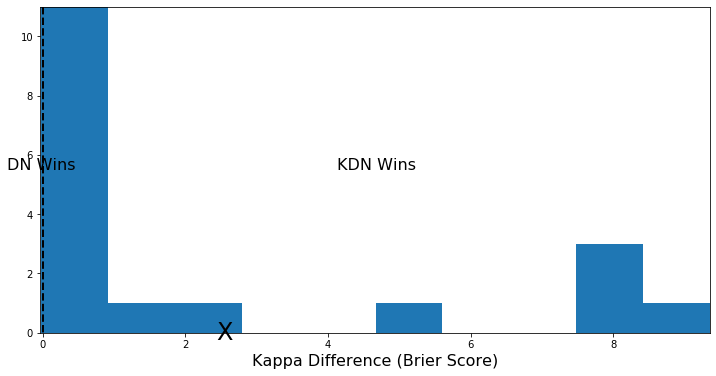

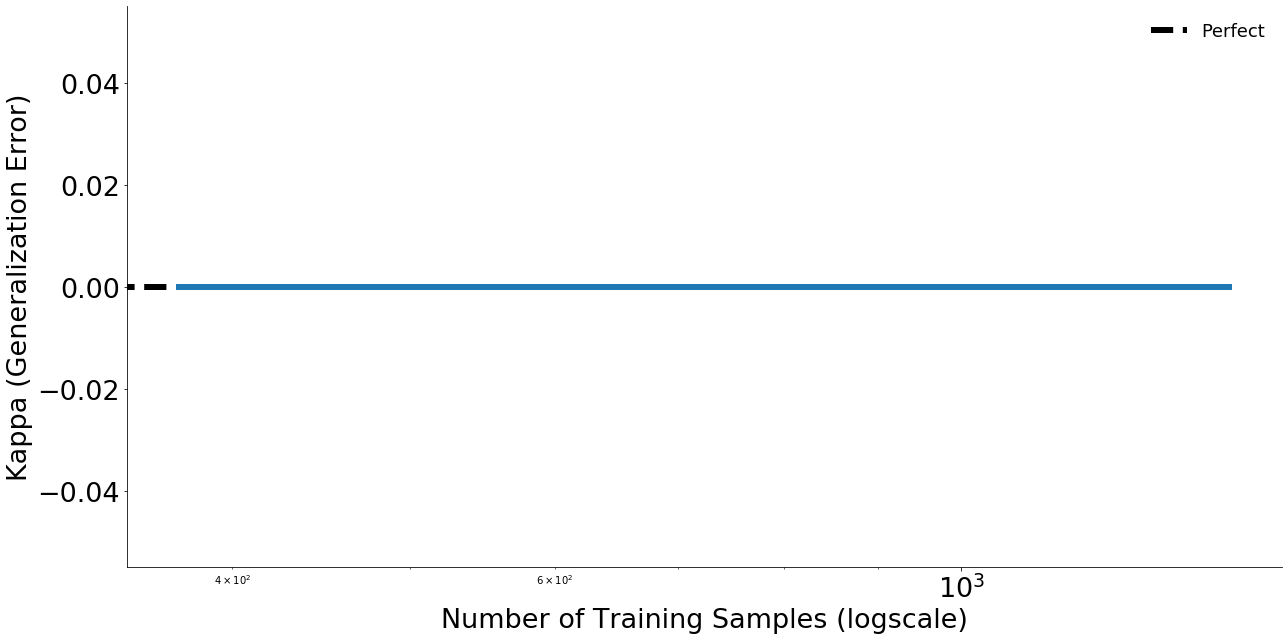

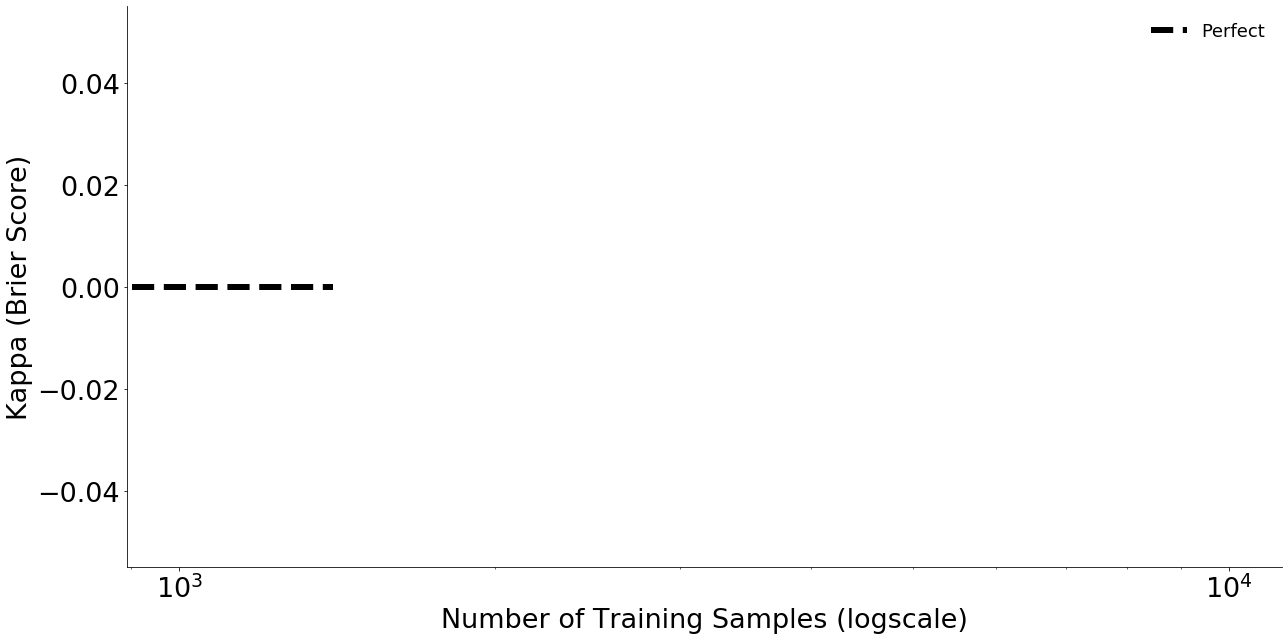

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


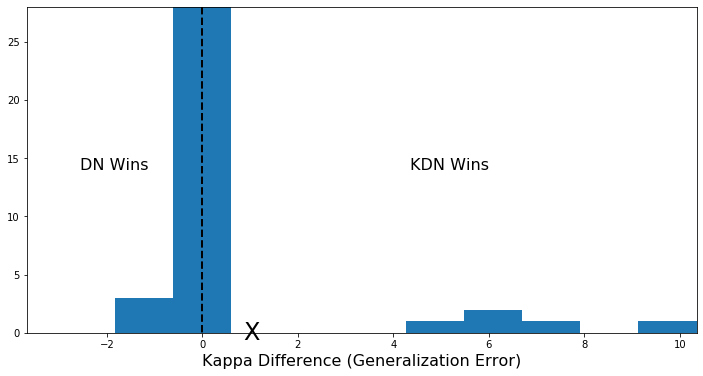

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


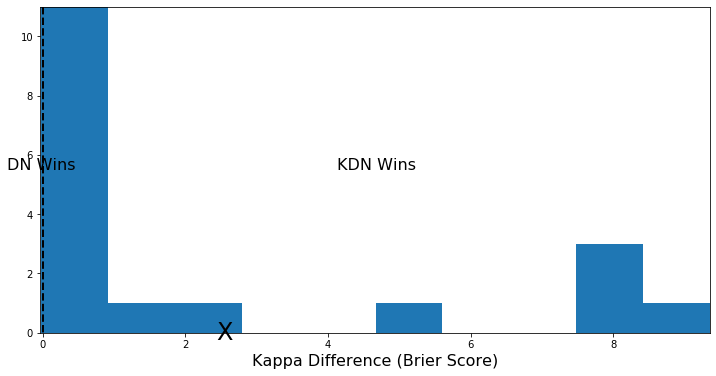

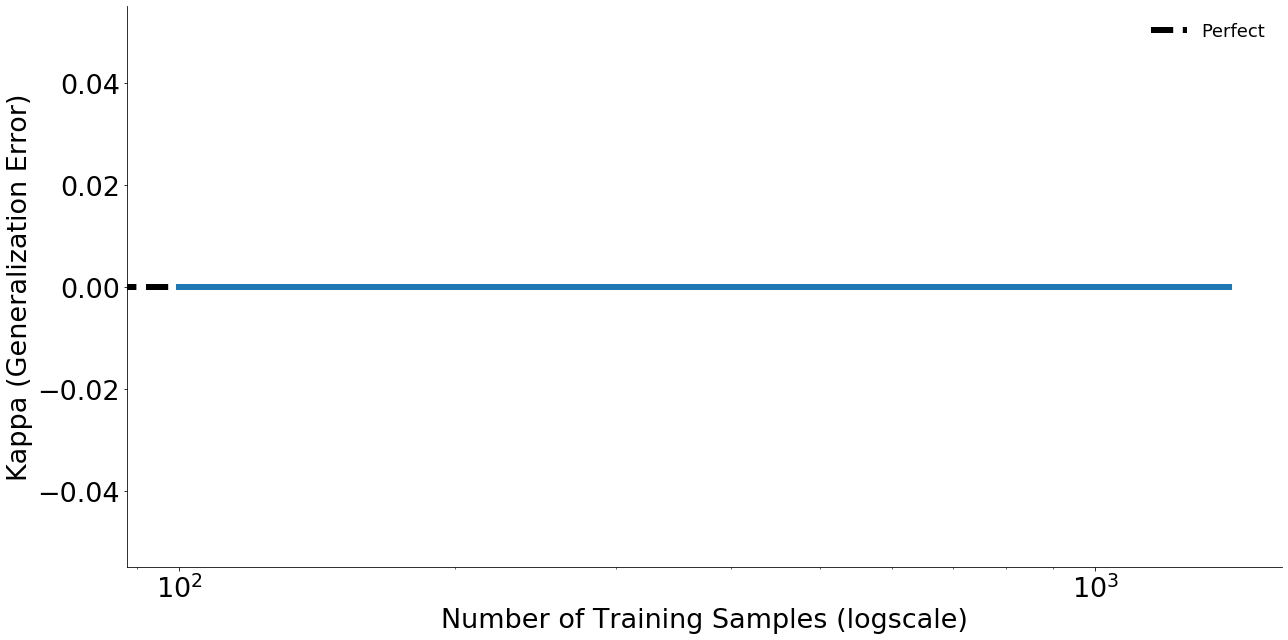

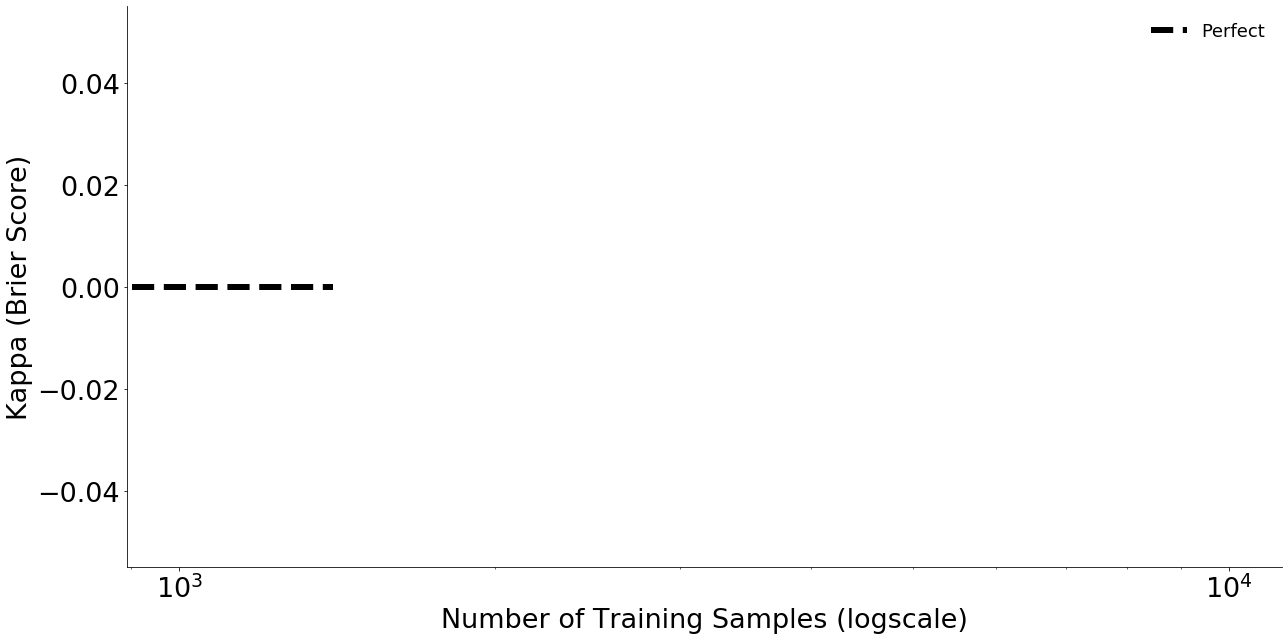

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


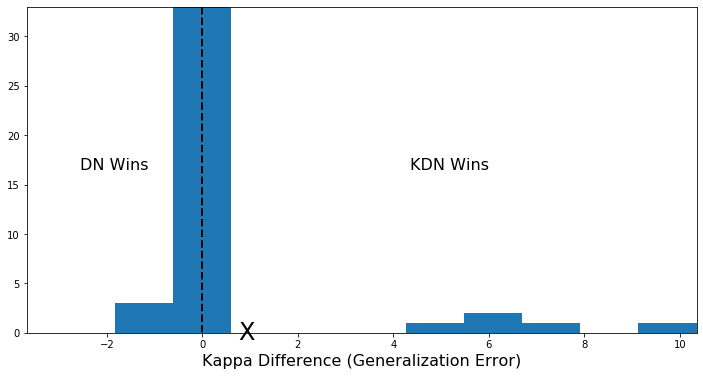

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


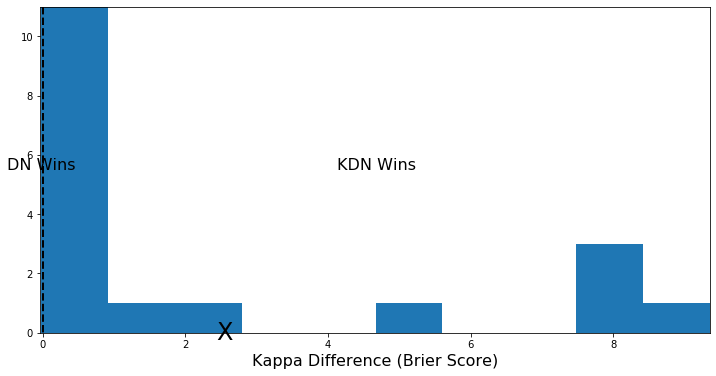

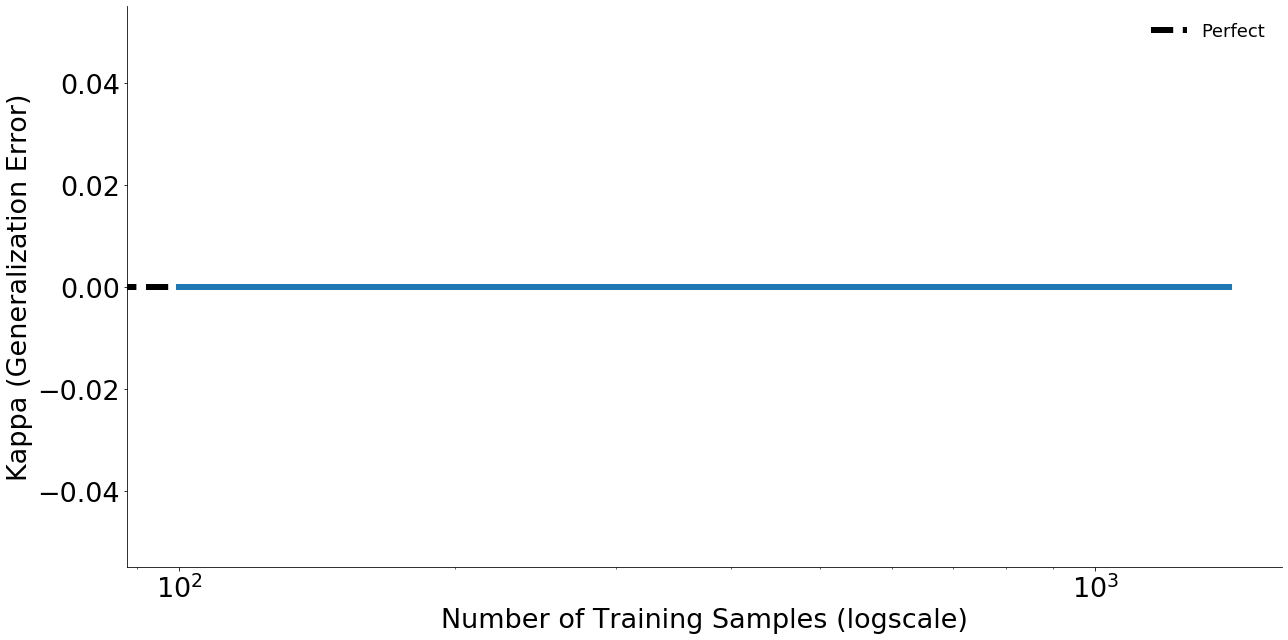

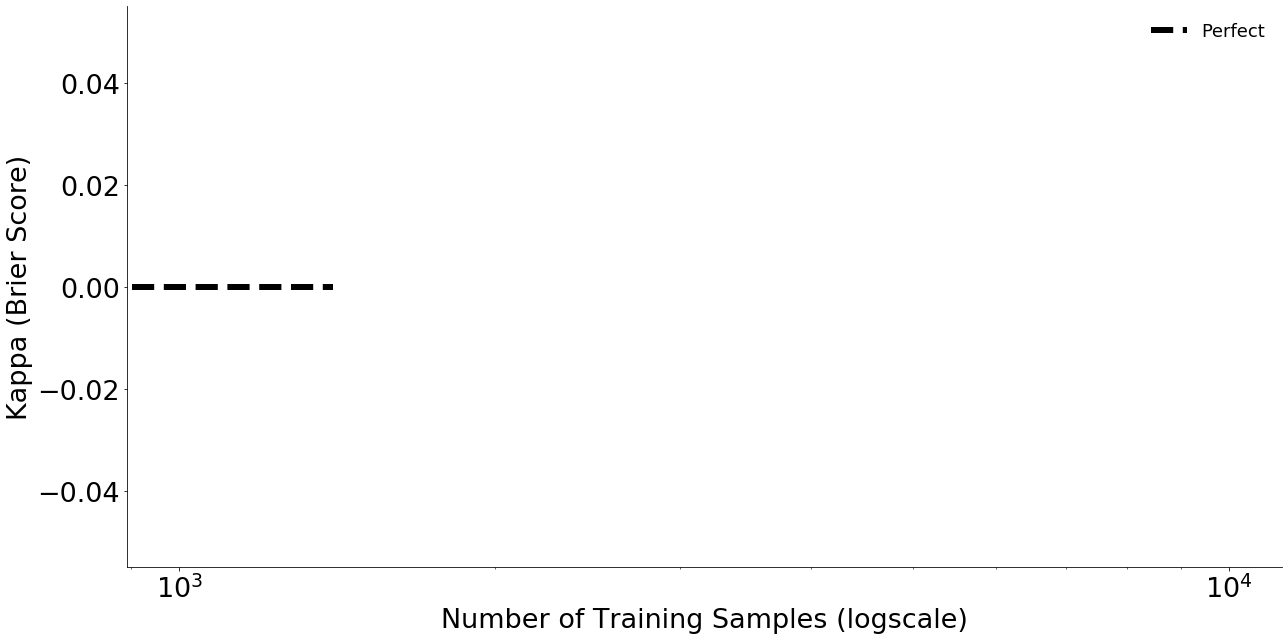

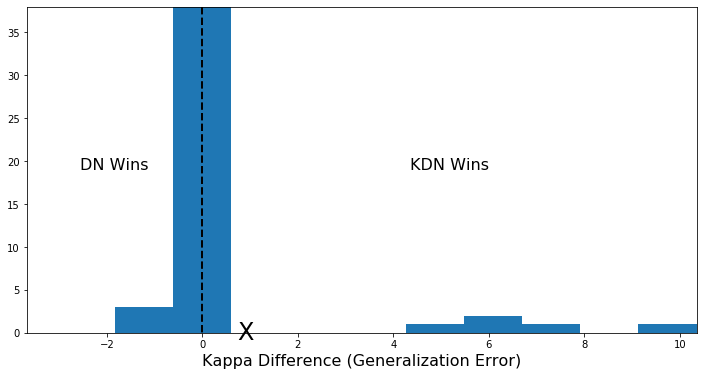

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


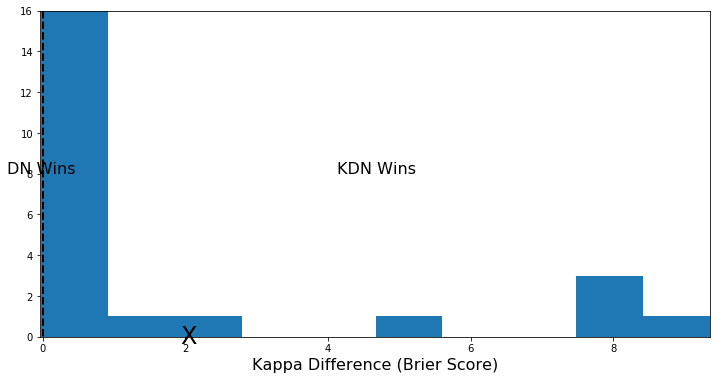

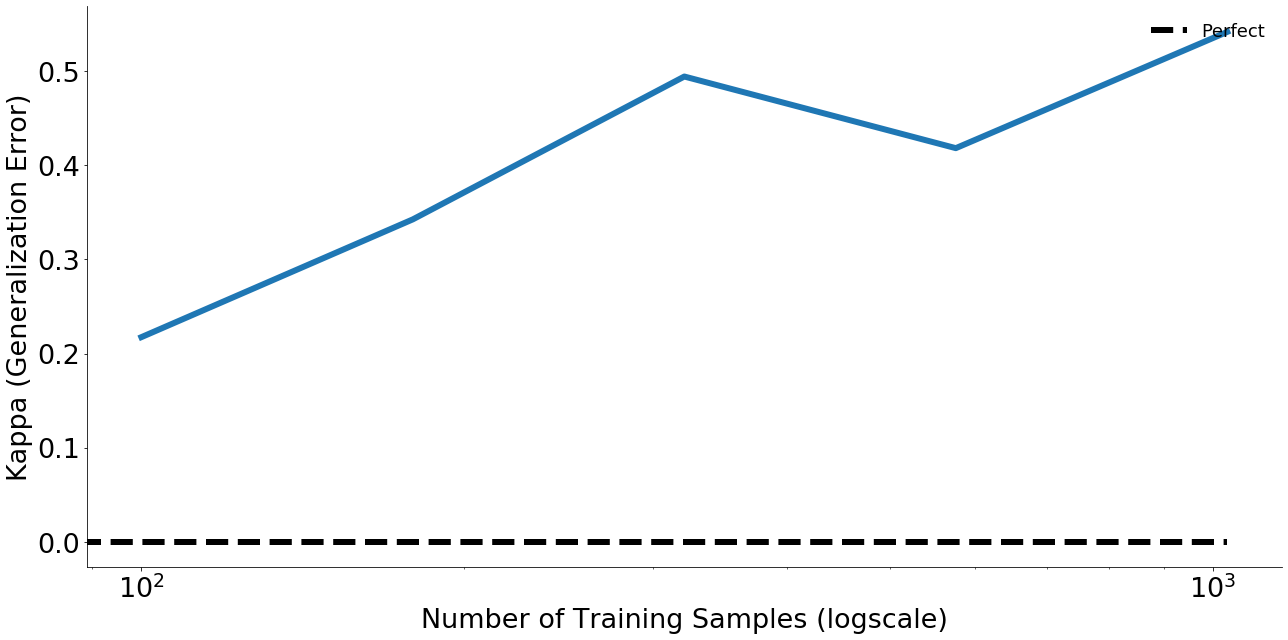

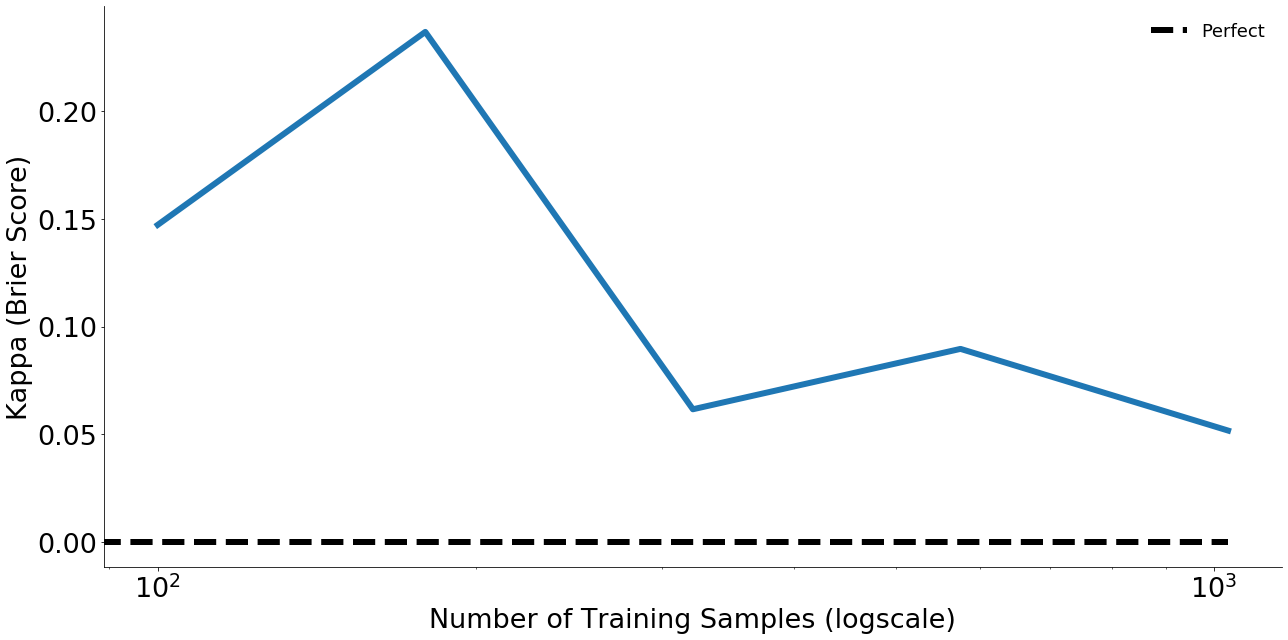

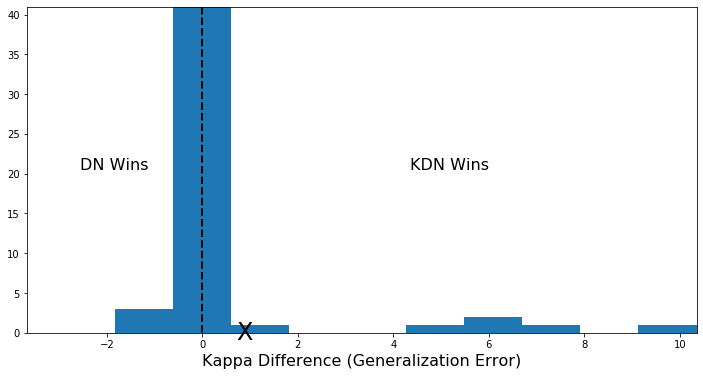

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


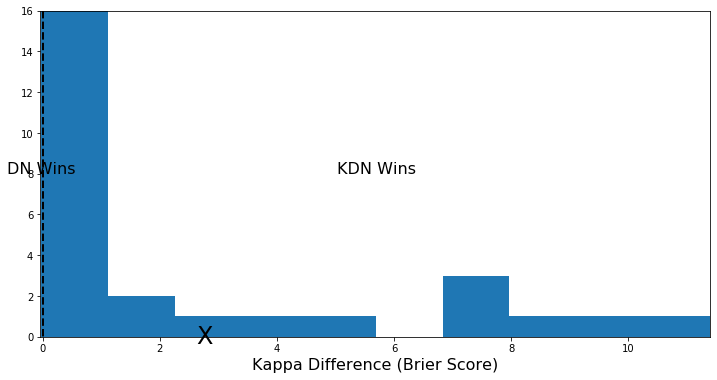

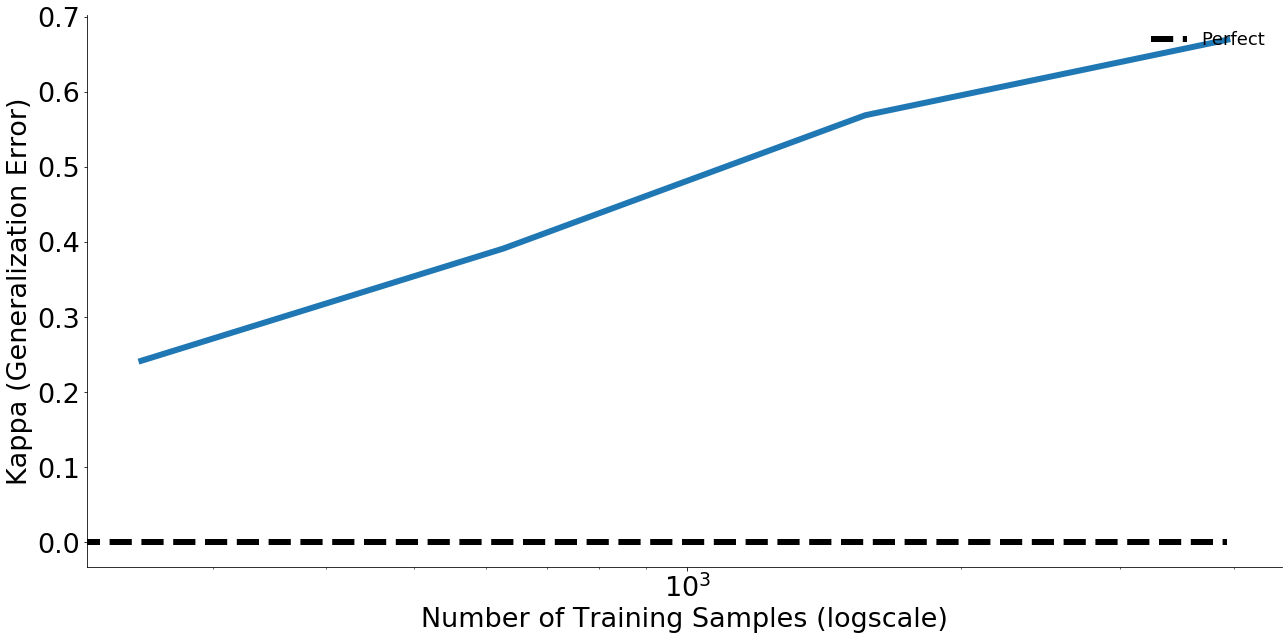

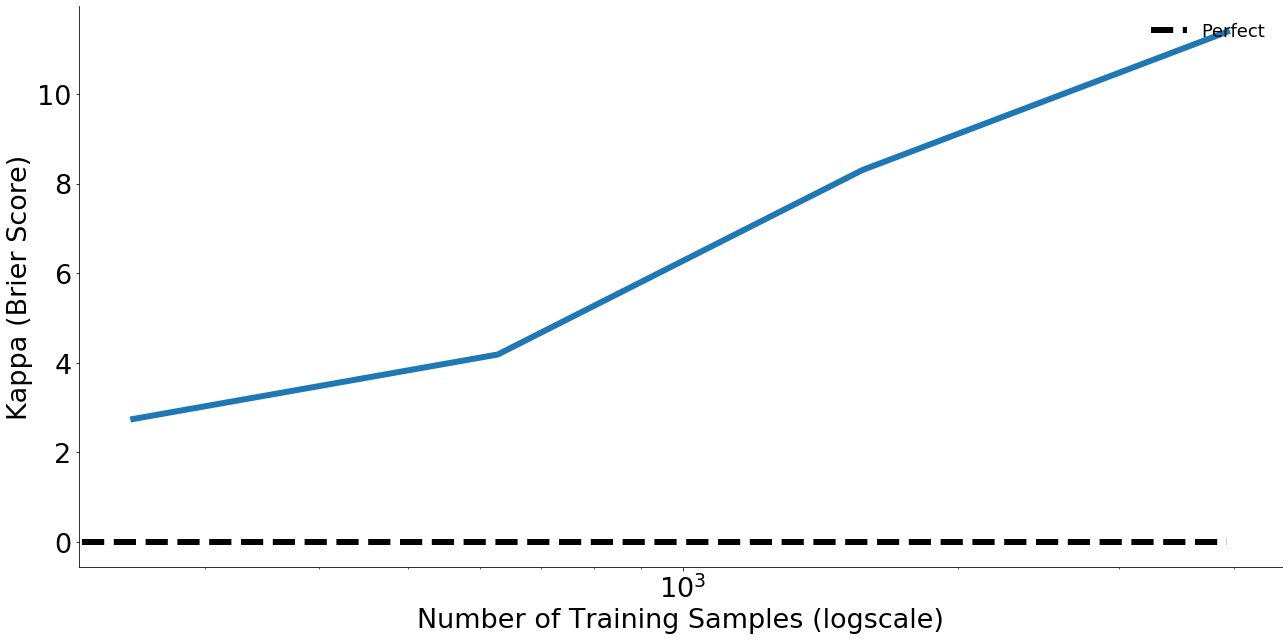

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


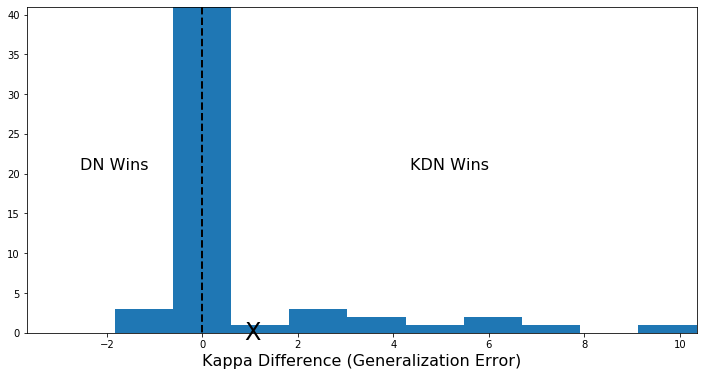

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


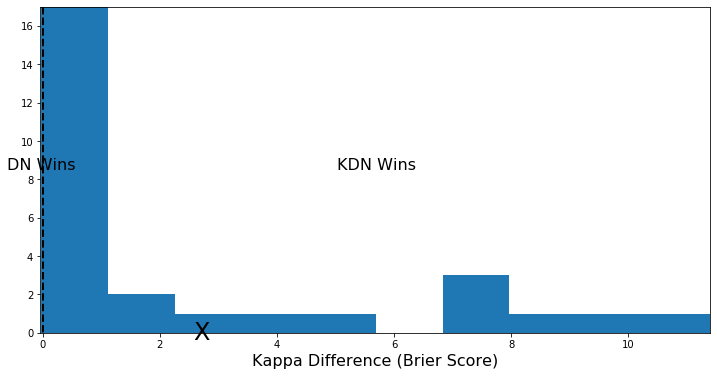

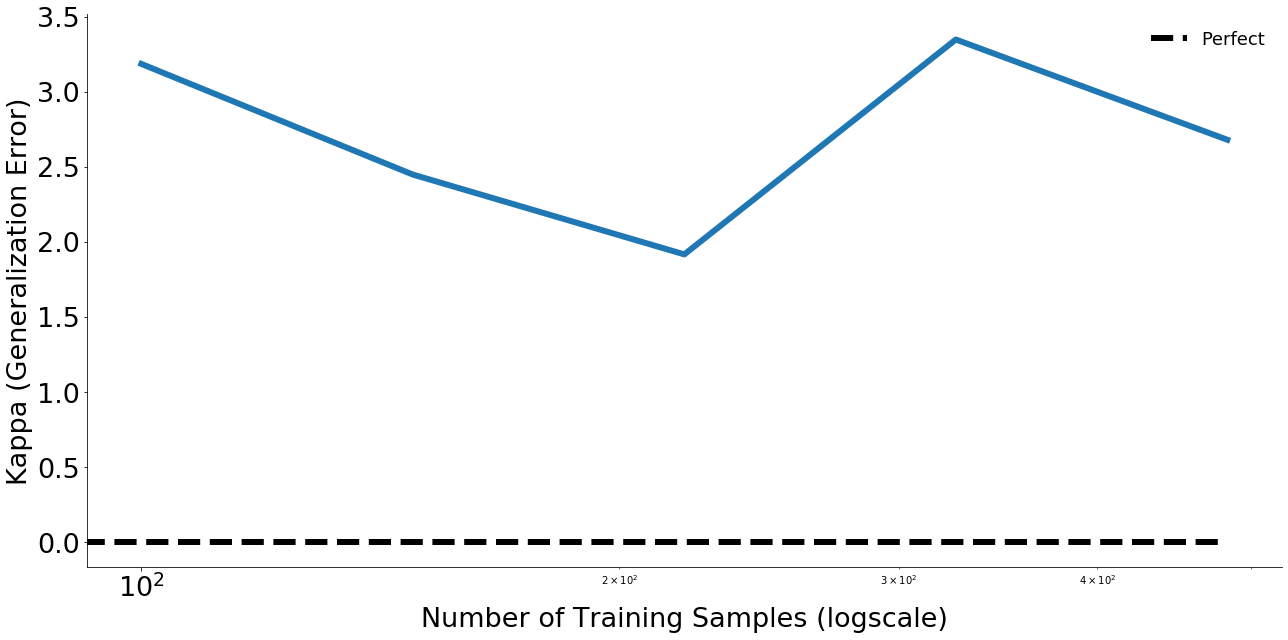

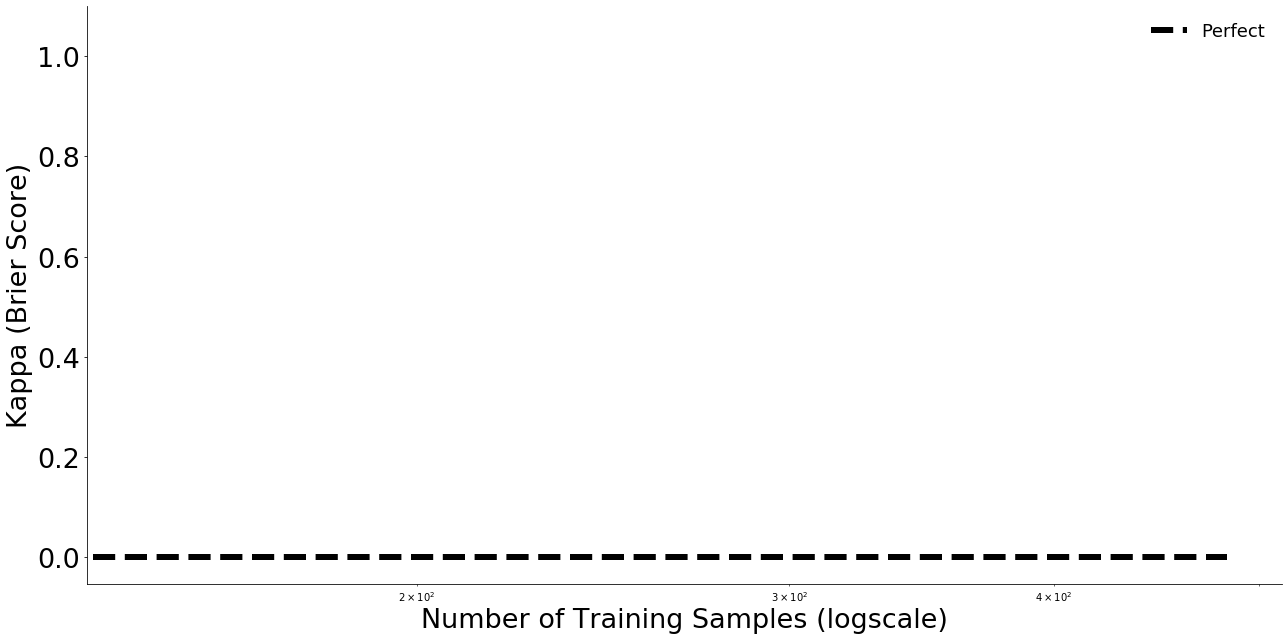

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater


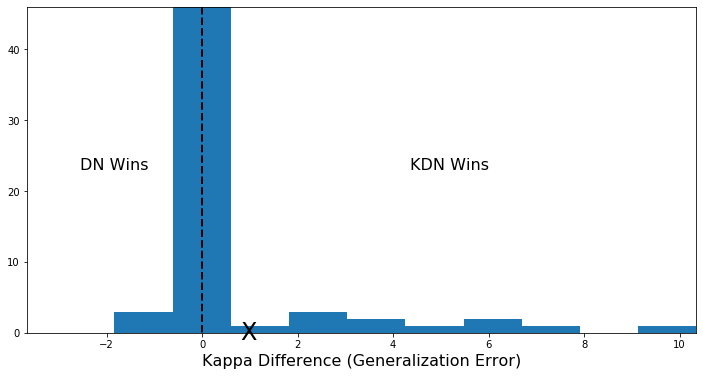

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


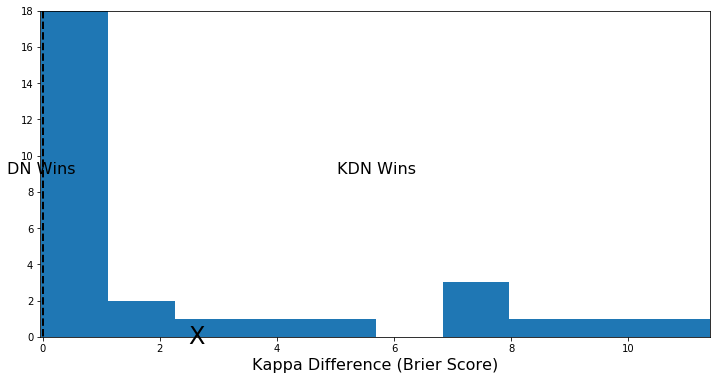

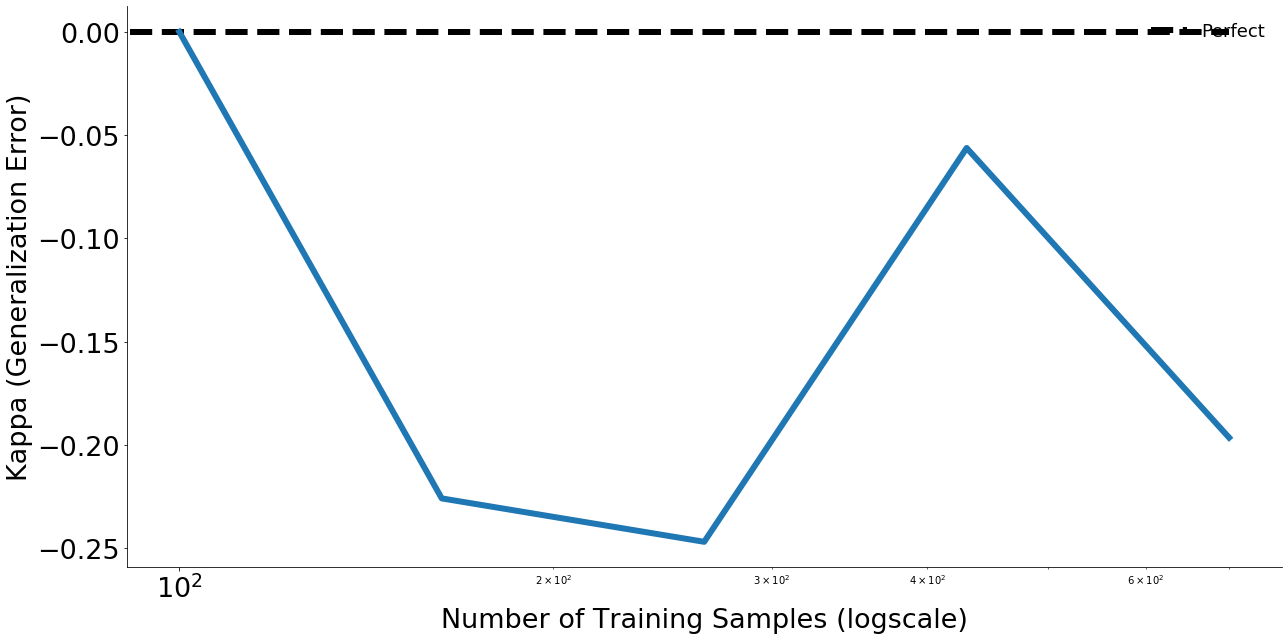

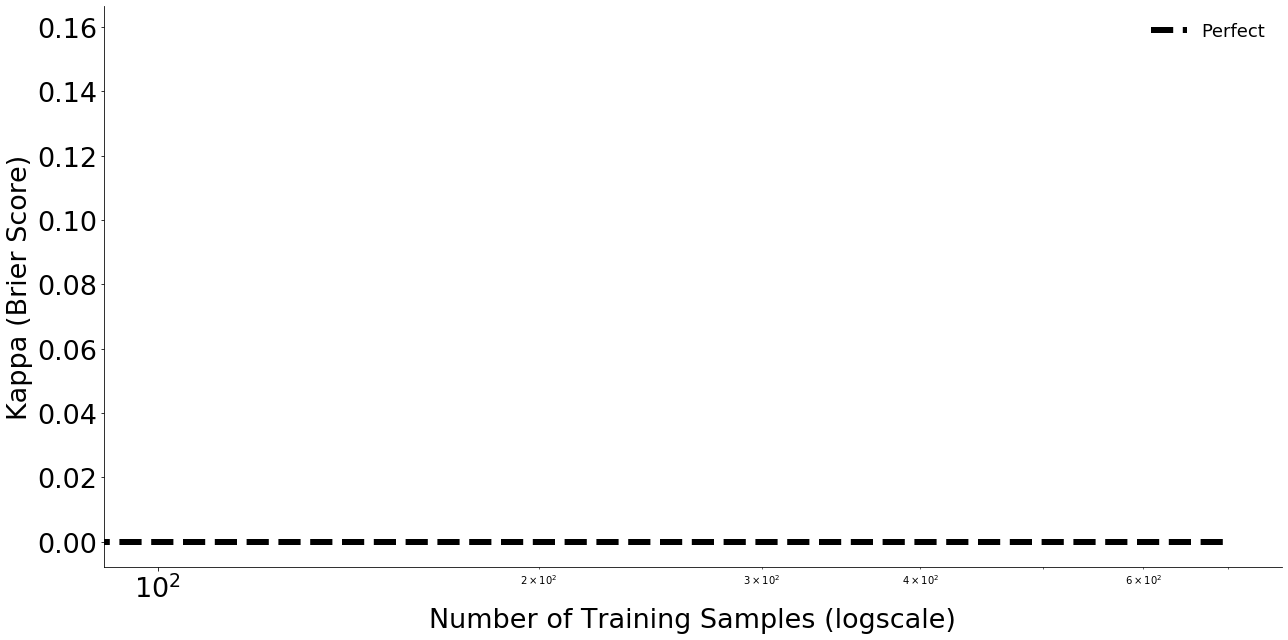

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


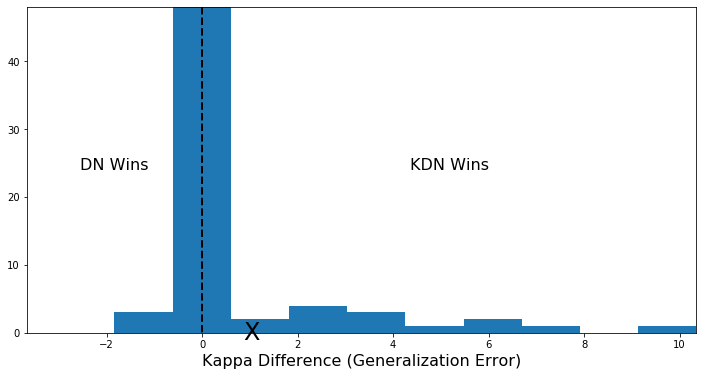

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


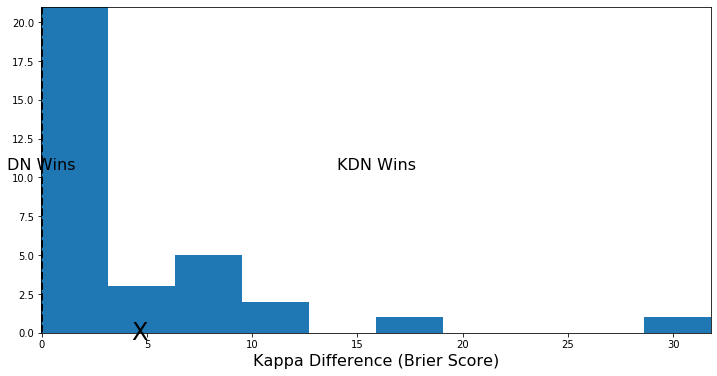

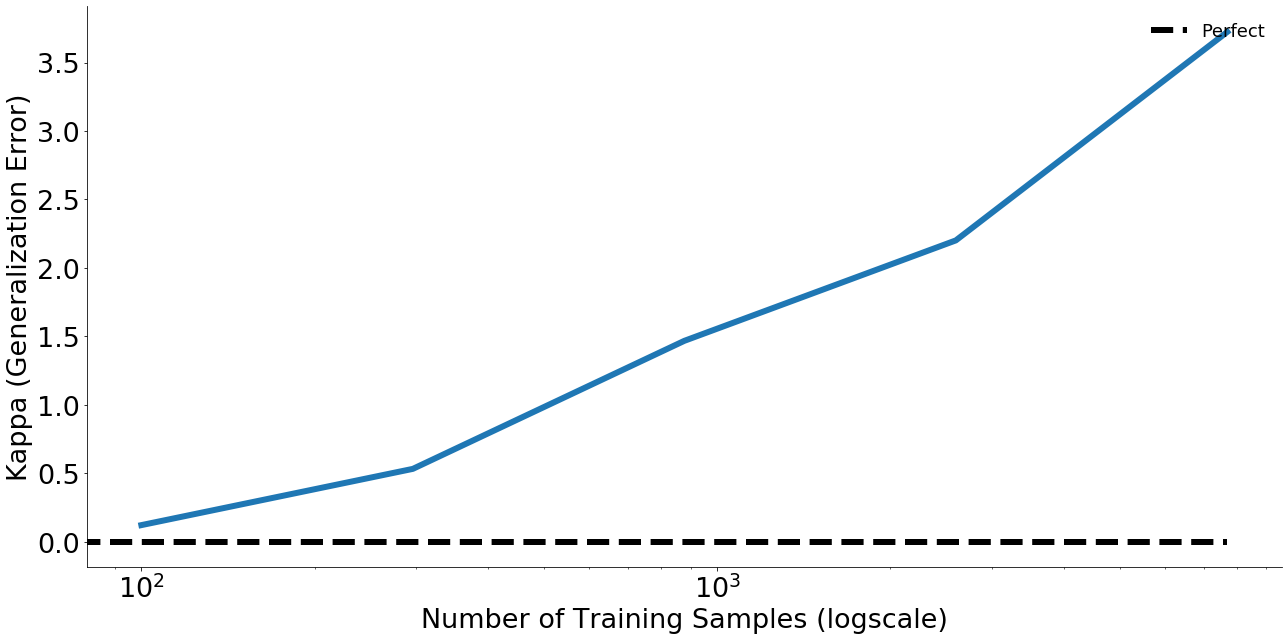

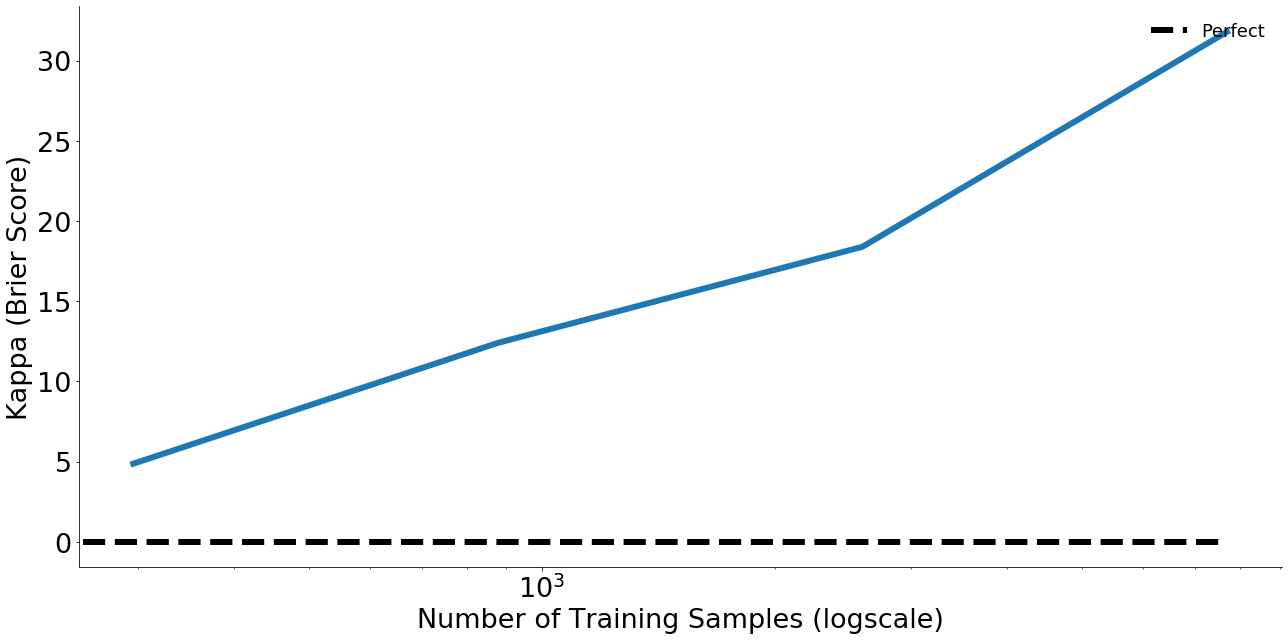

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


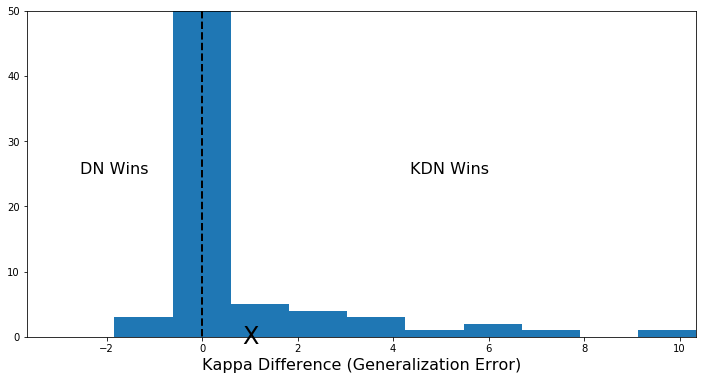

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


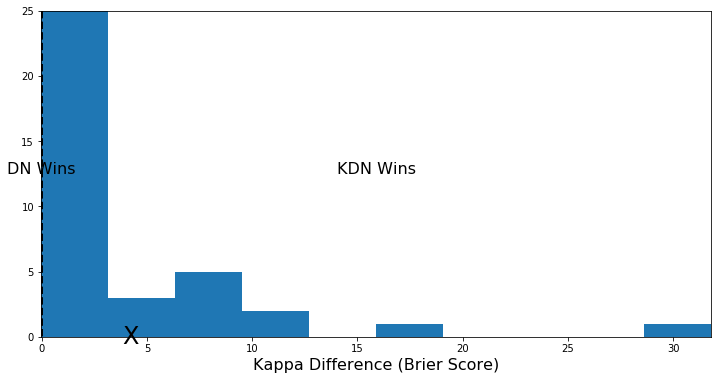

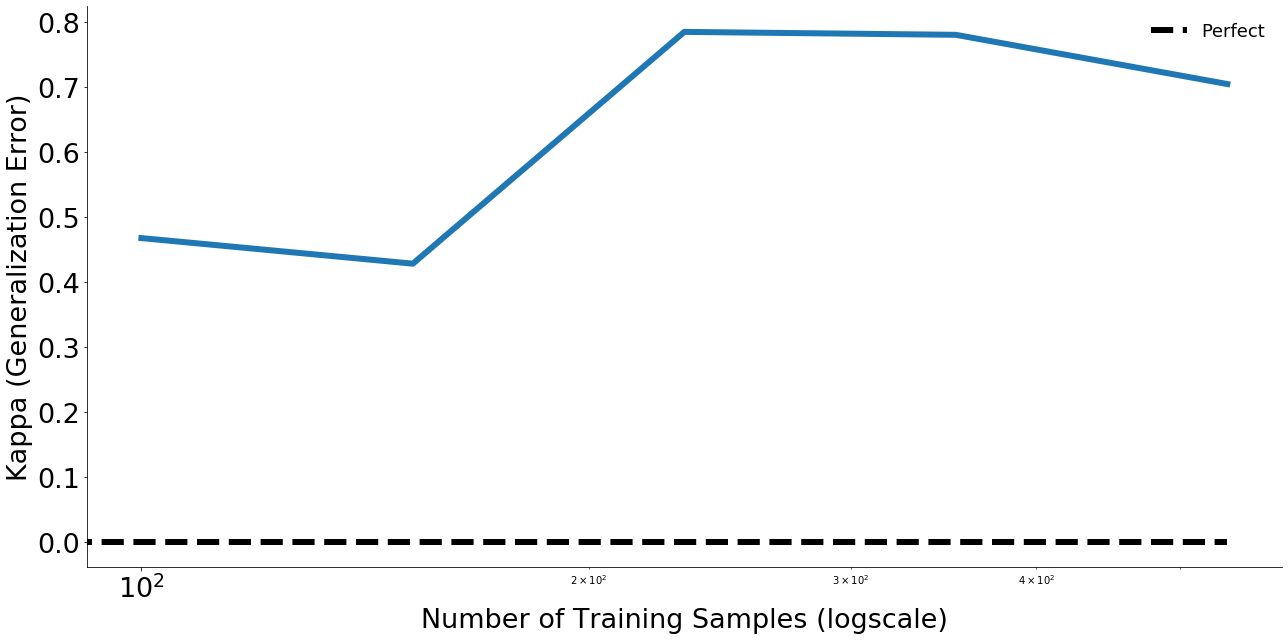

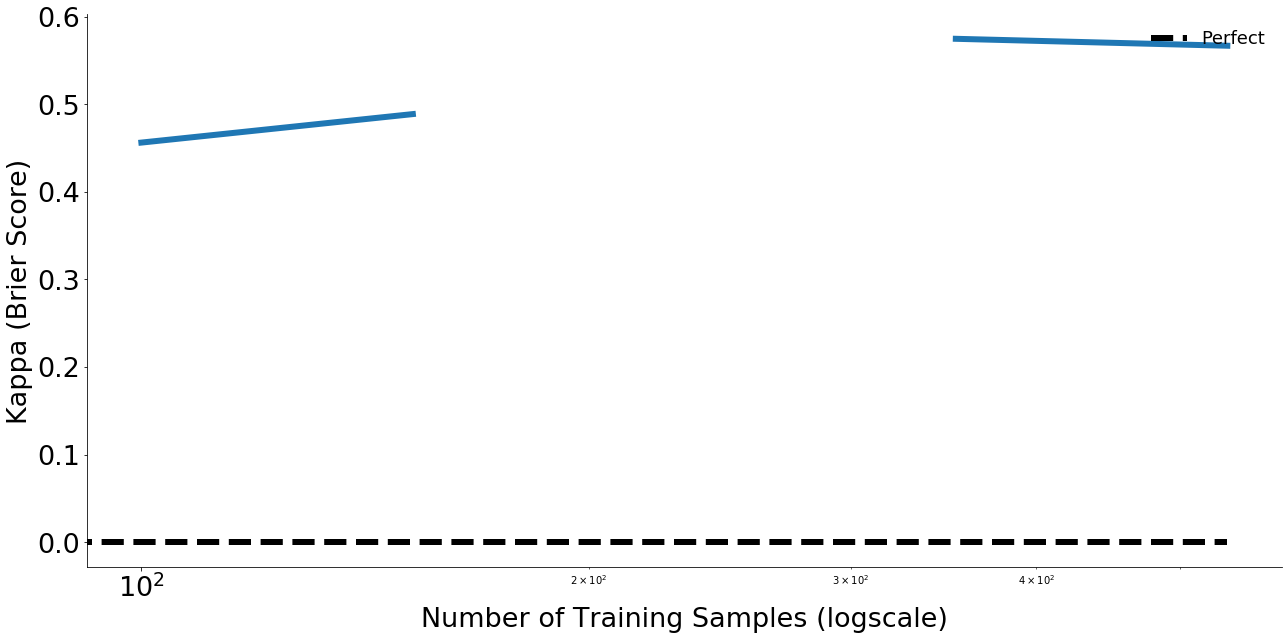

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


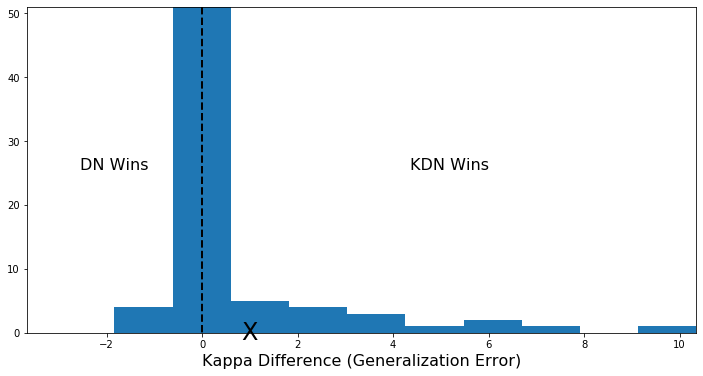

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


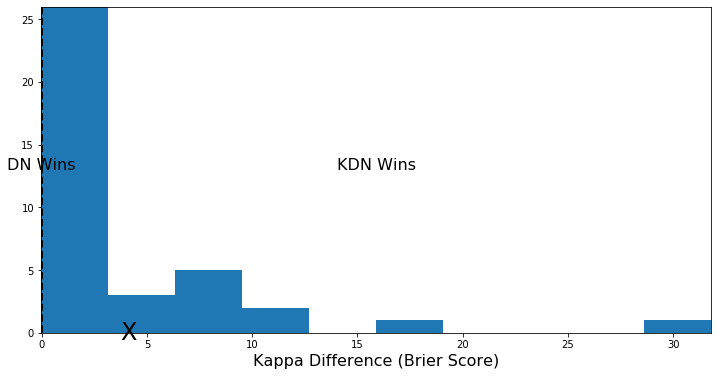

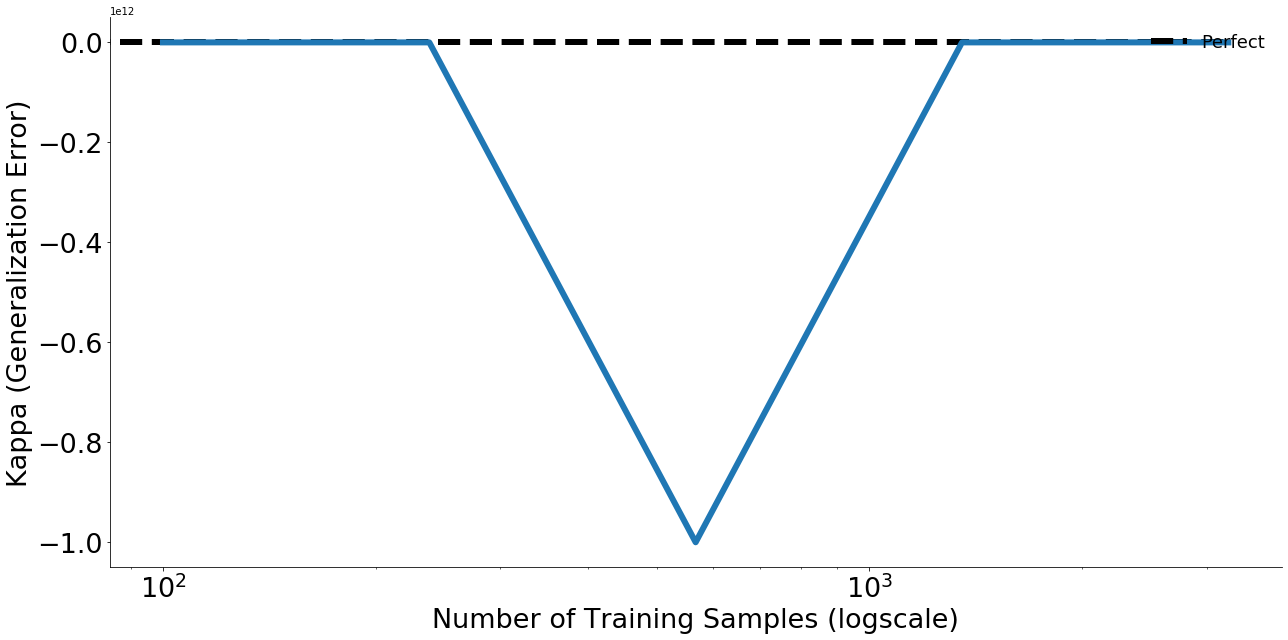

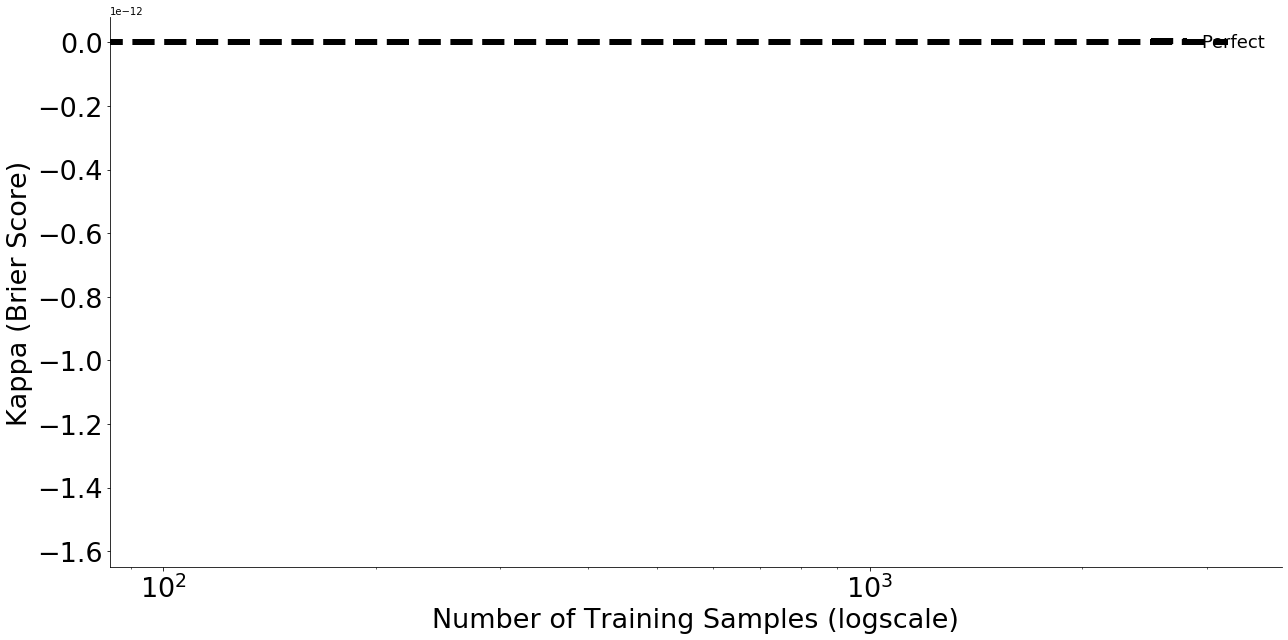

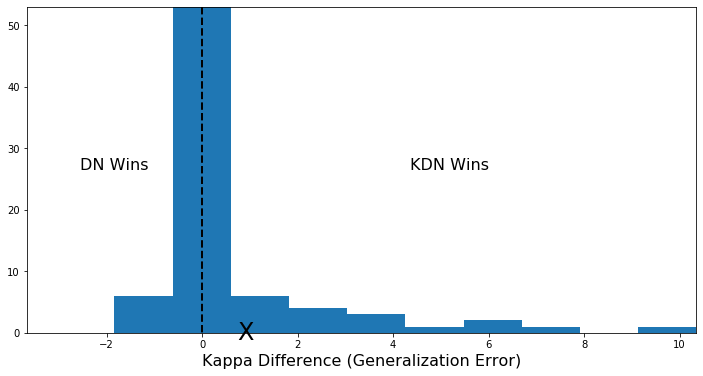

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


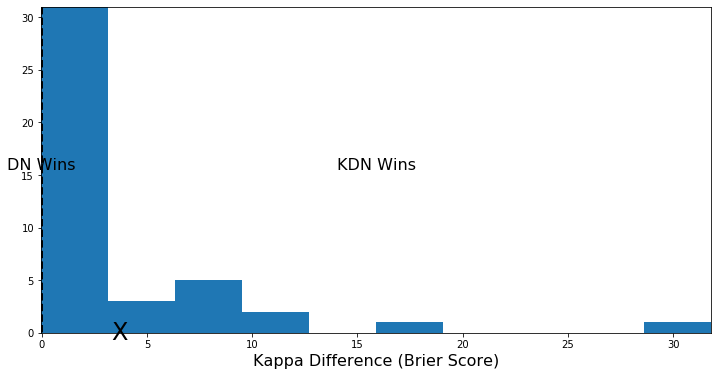

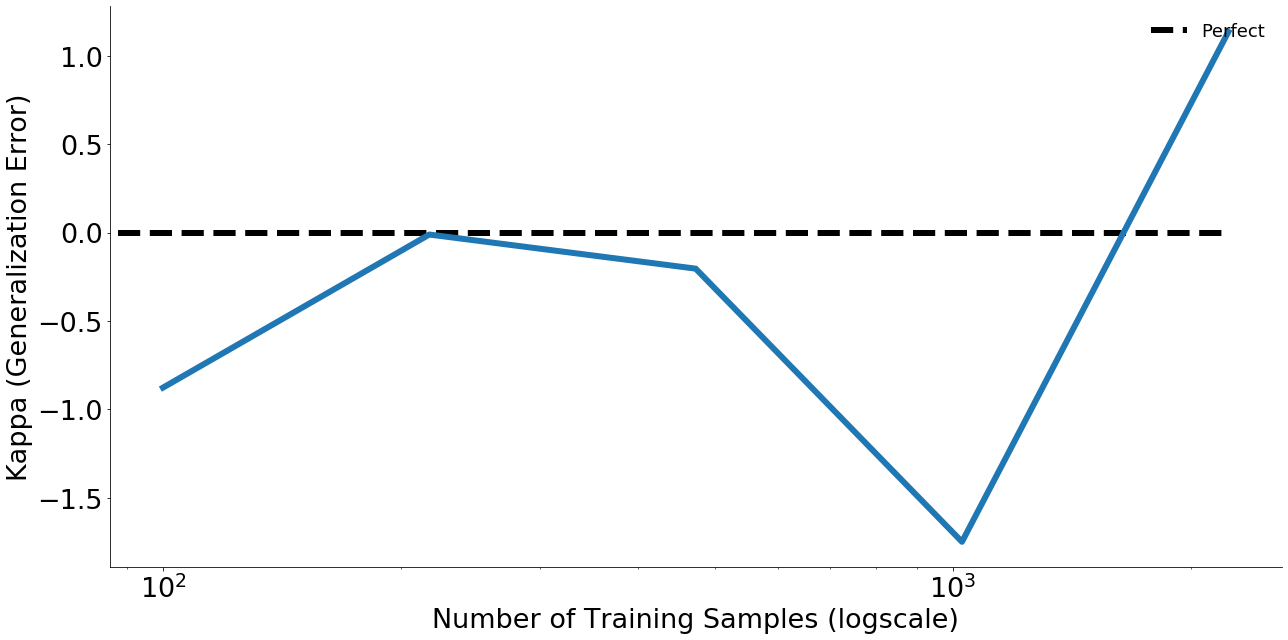

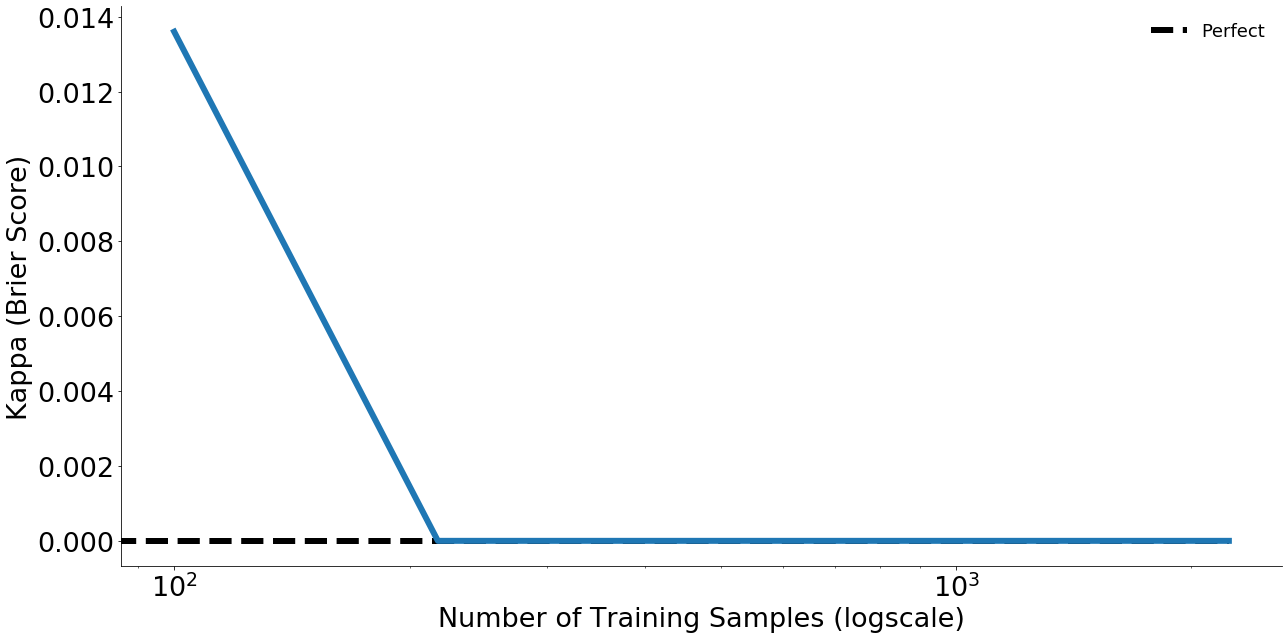

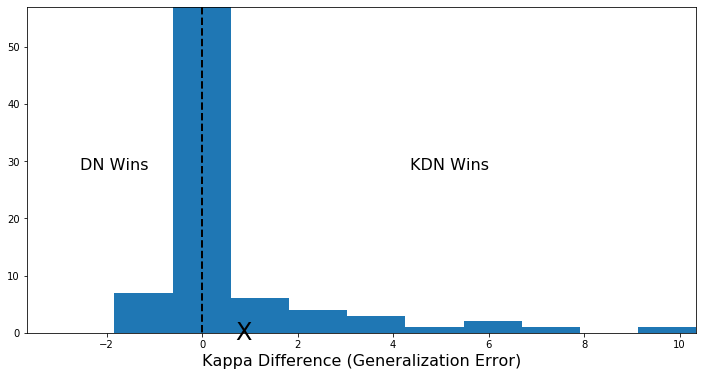

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


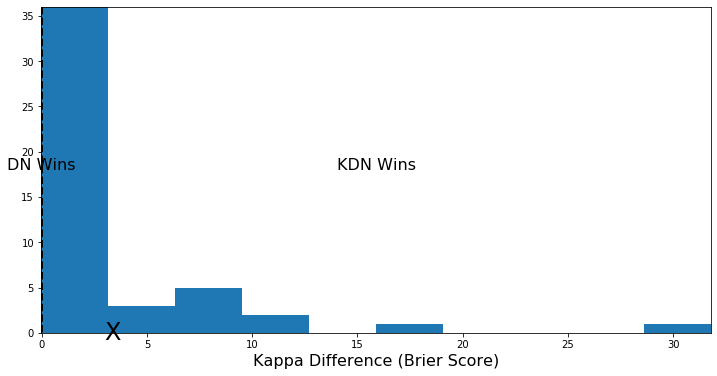

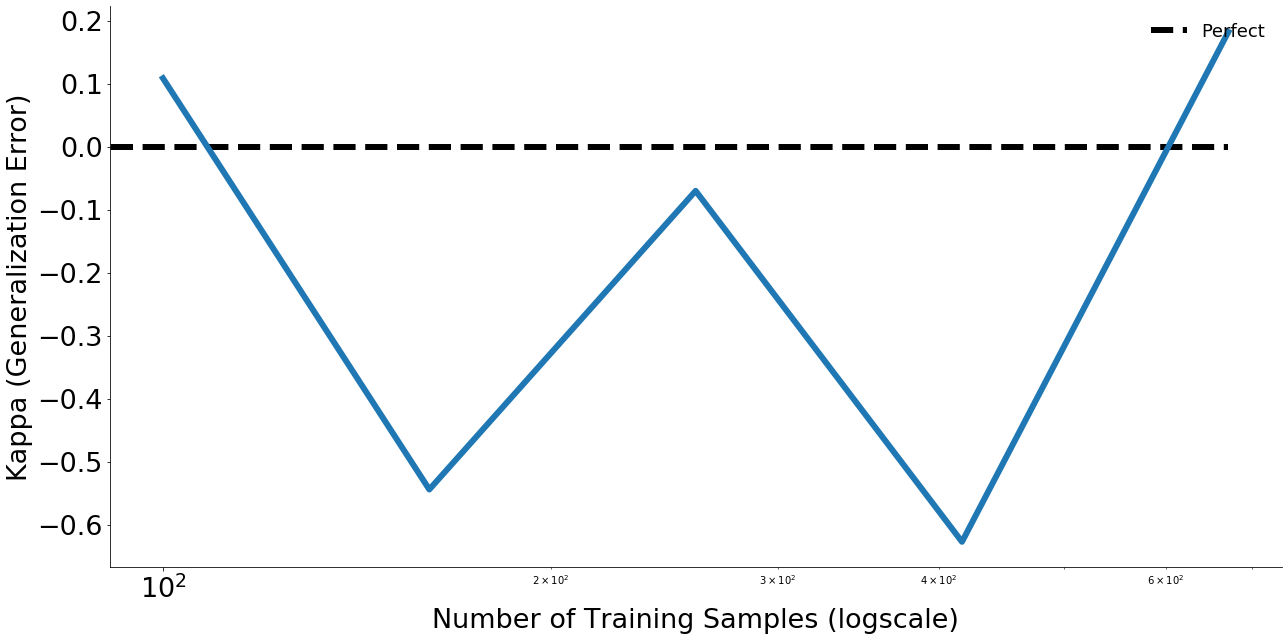

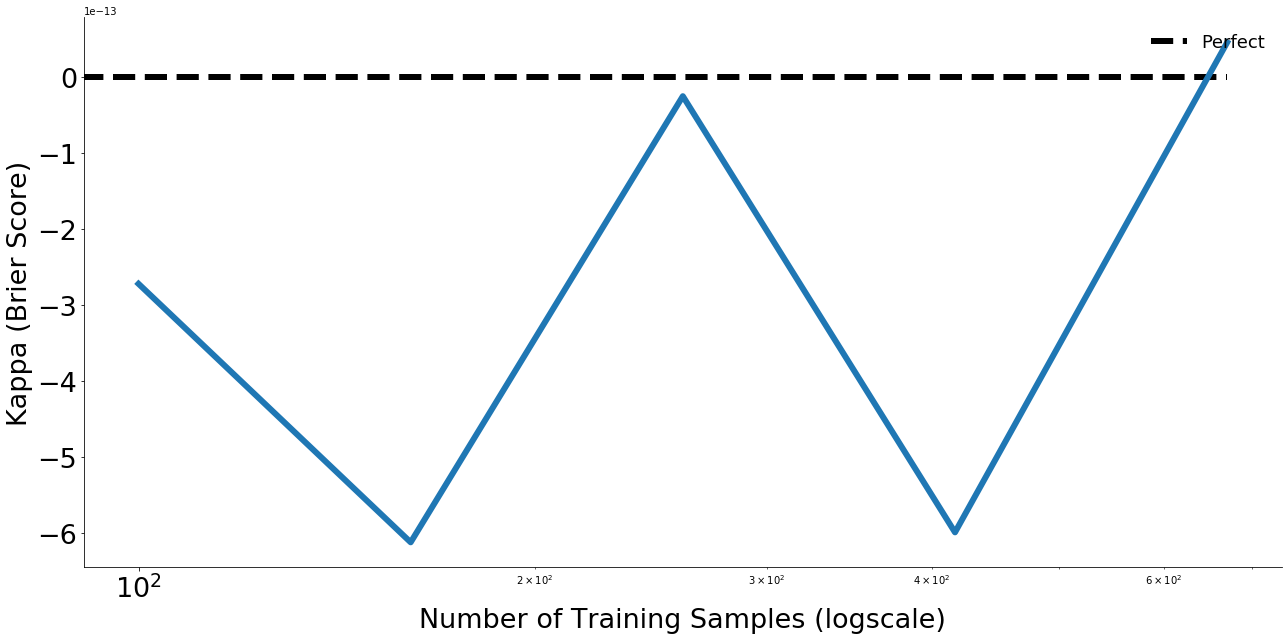

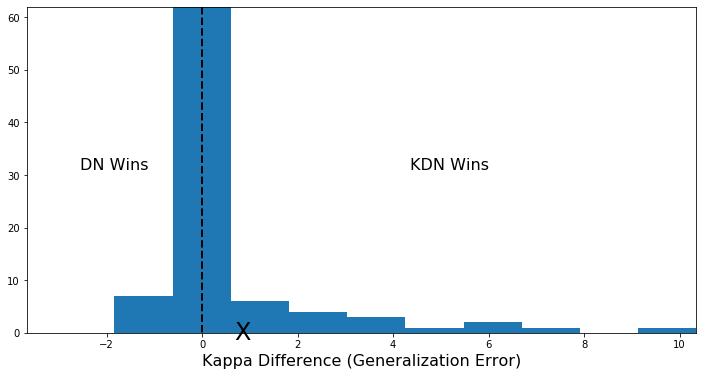

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


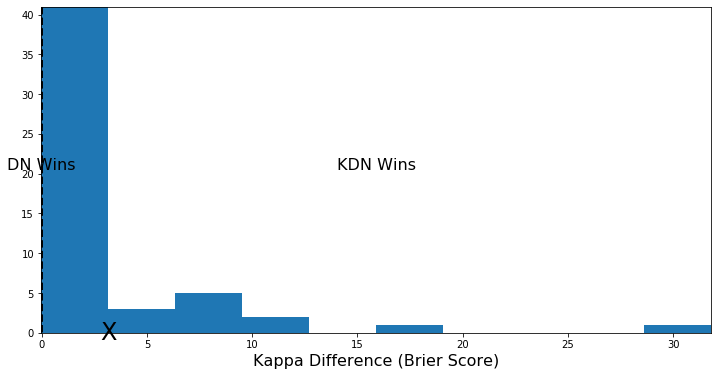

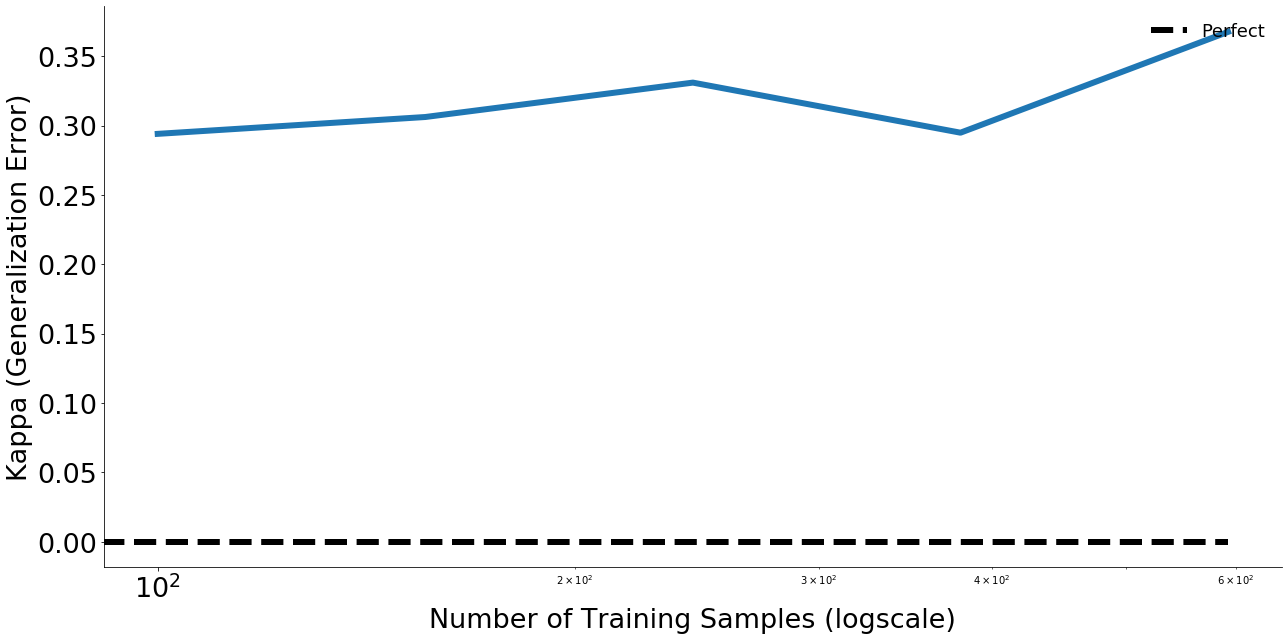

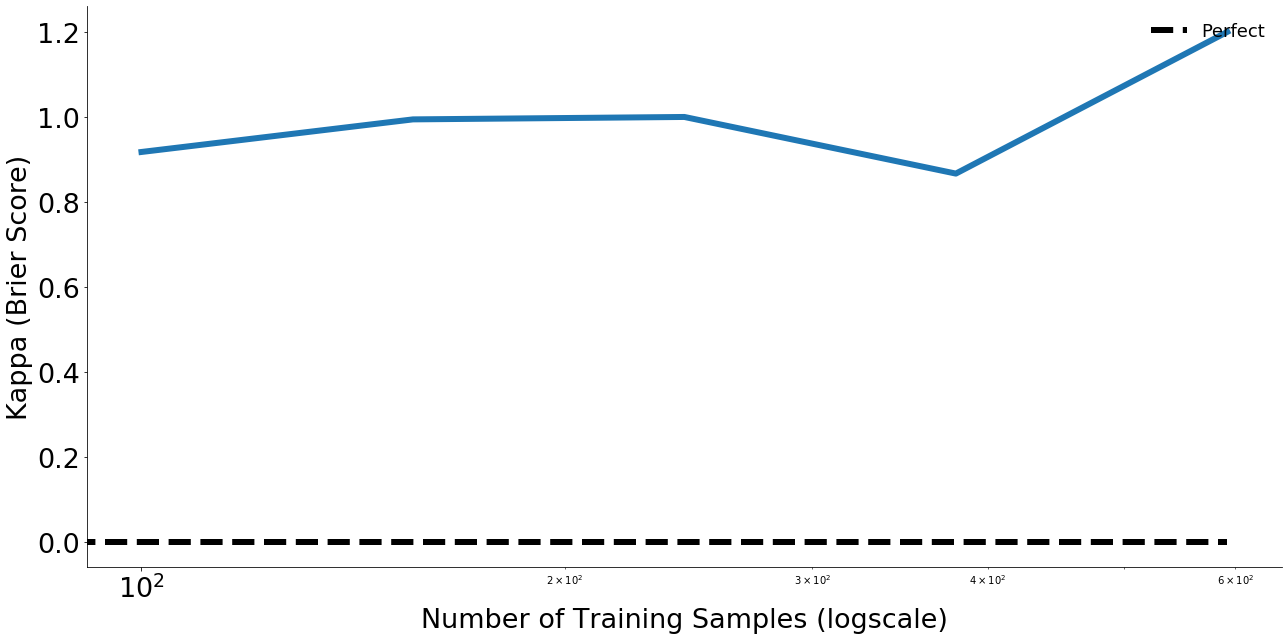

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


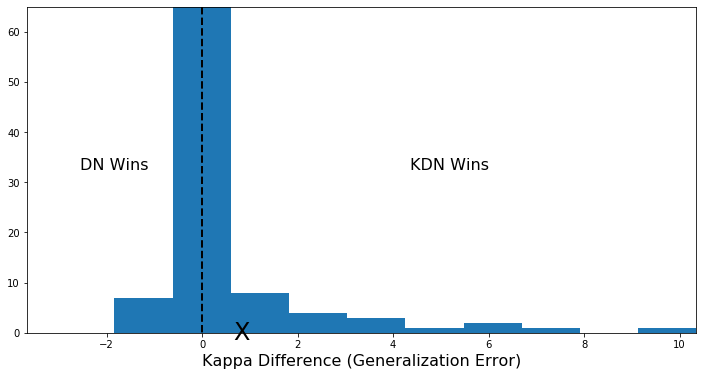

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


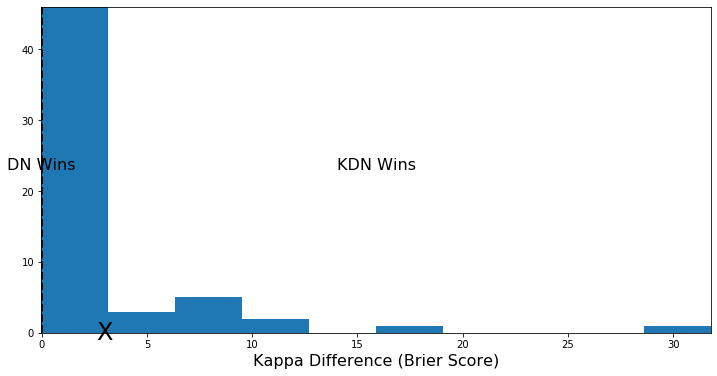

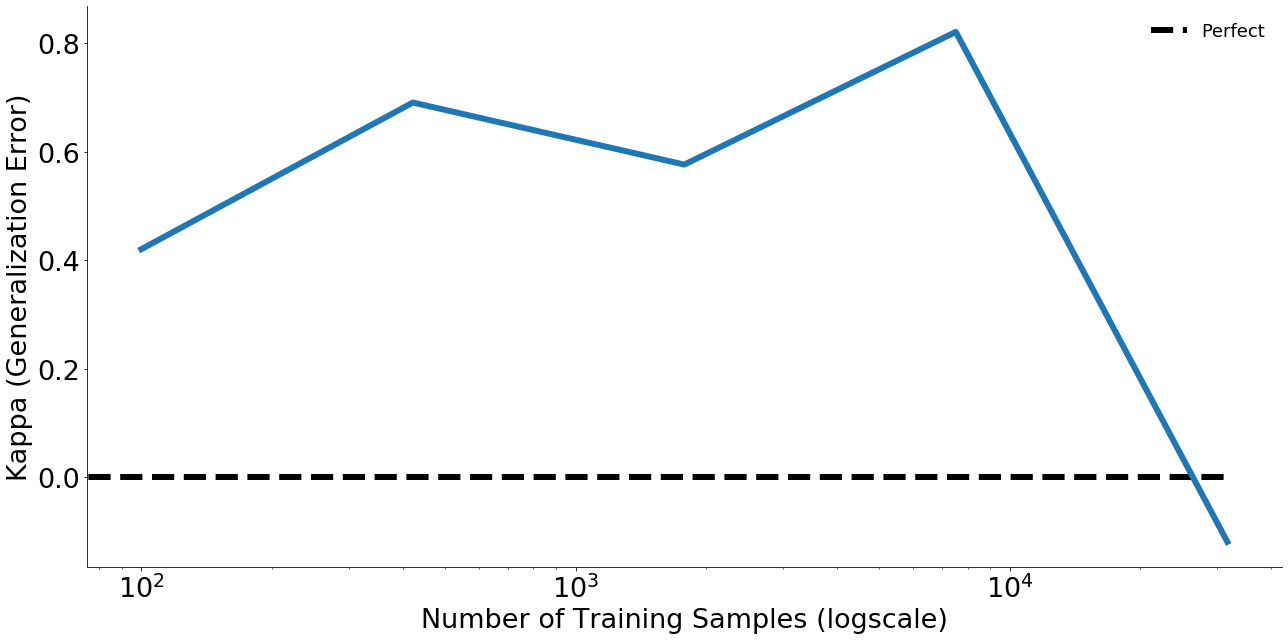

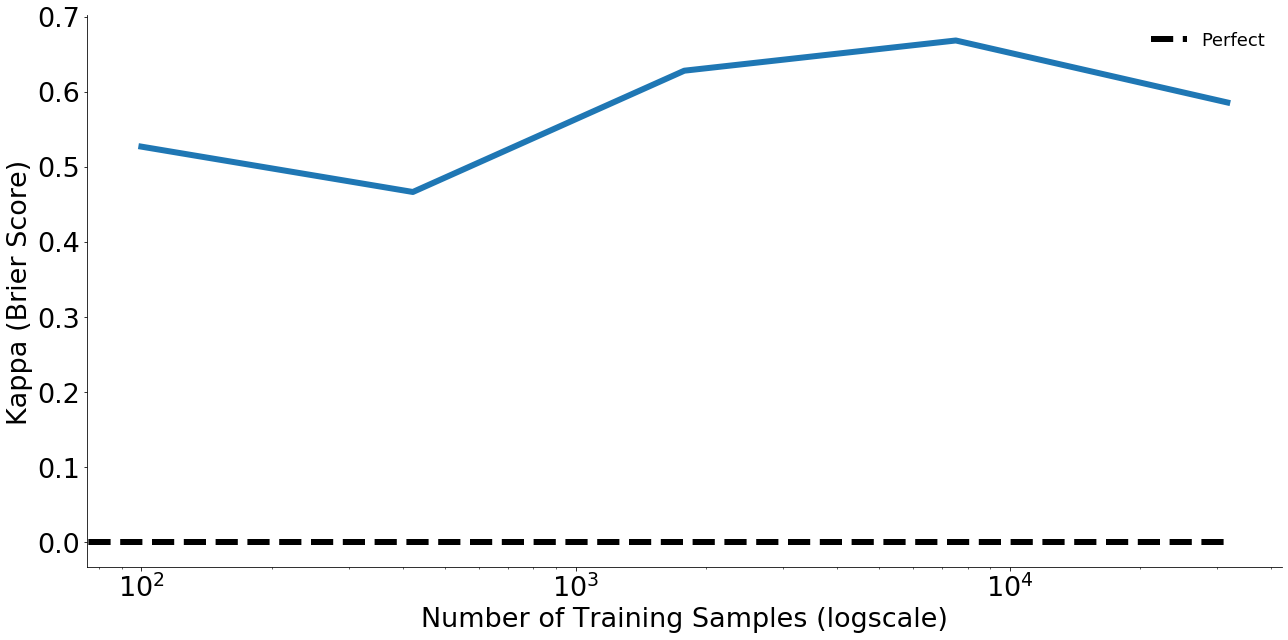

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


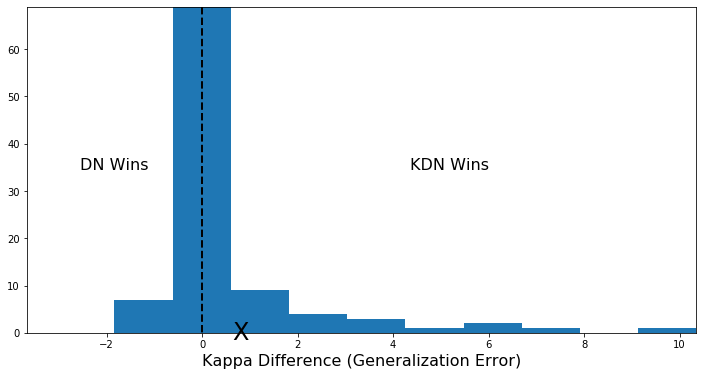

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


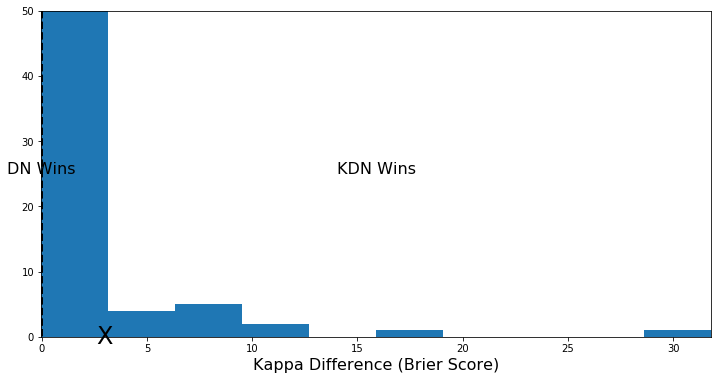

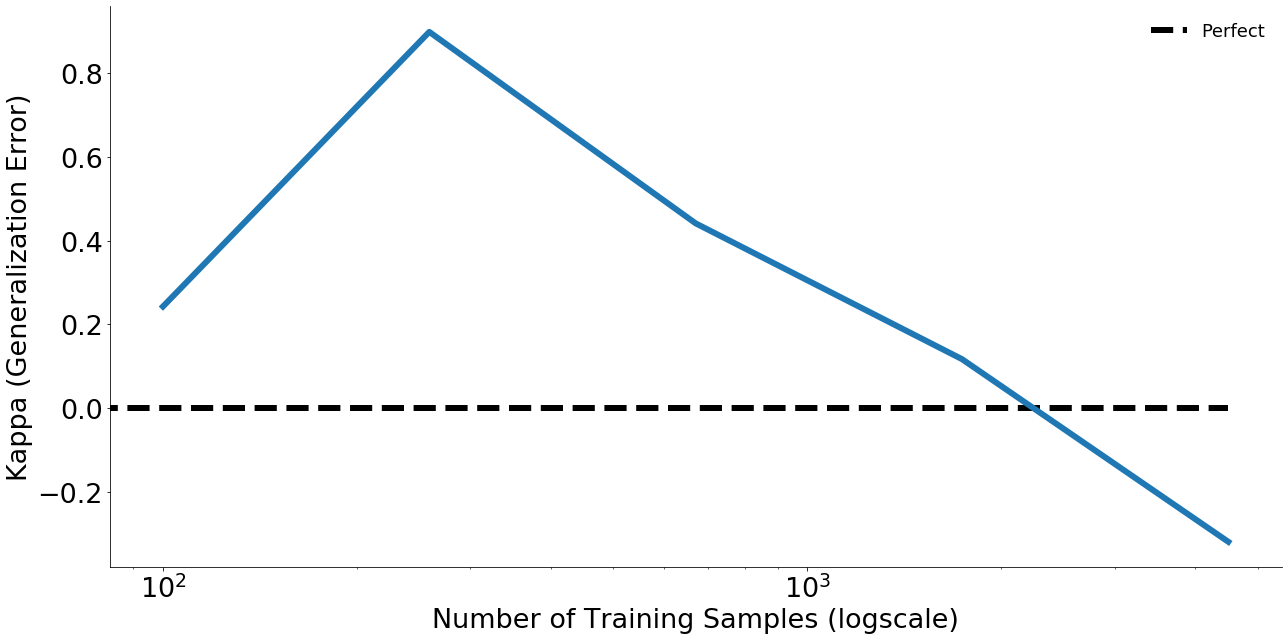

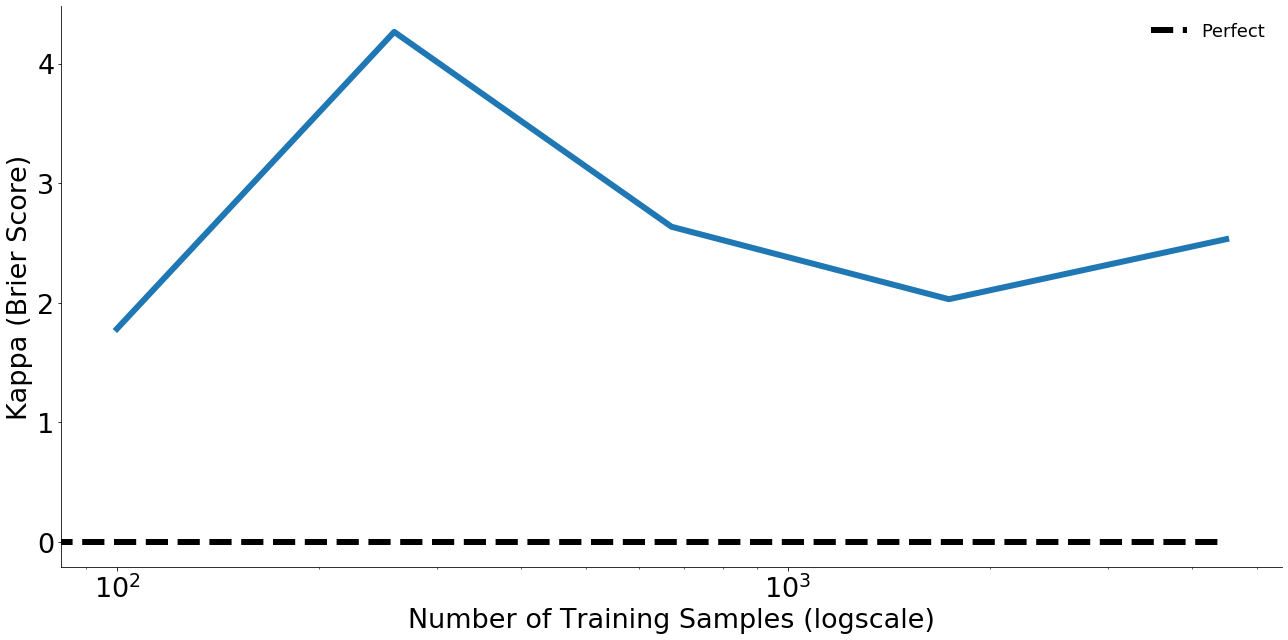

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


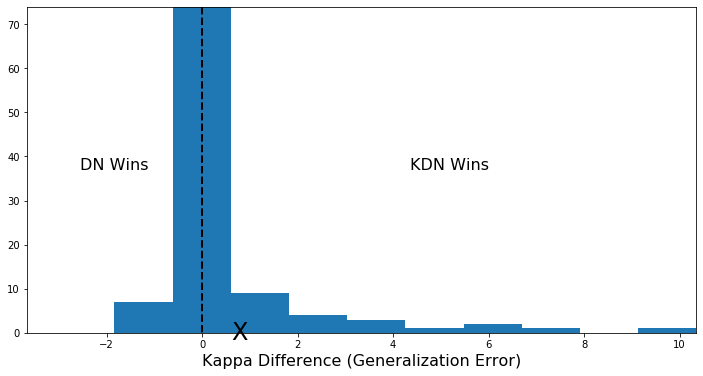

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


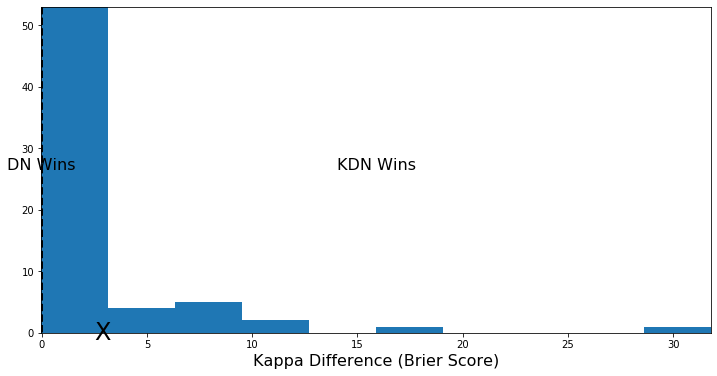

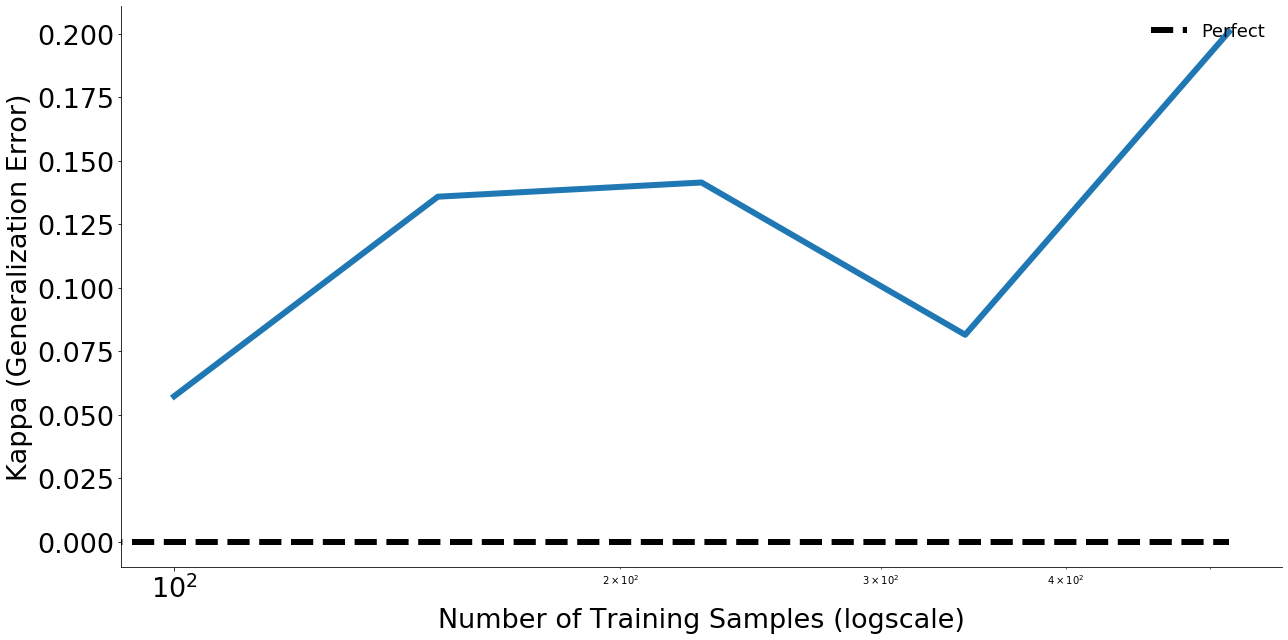

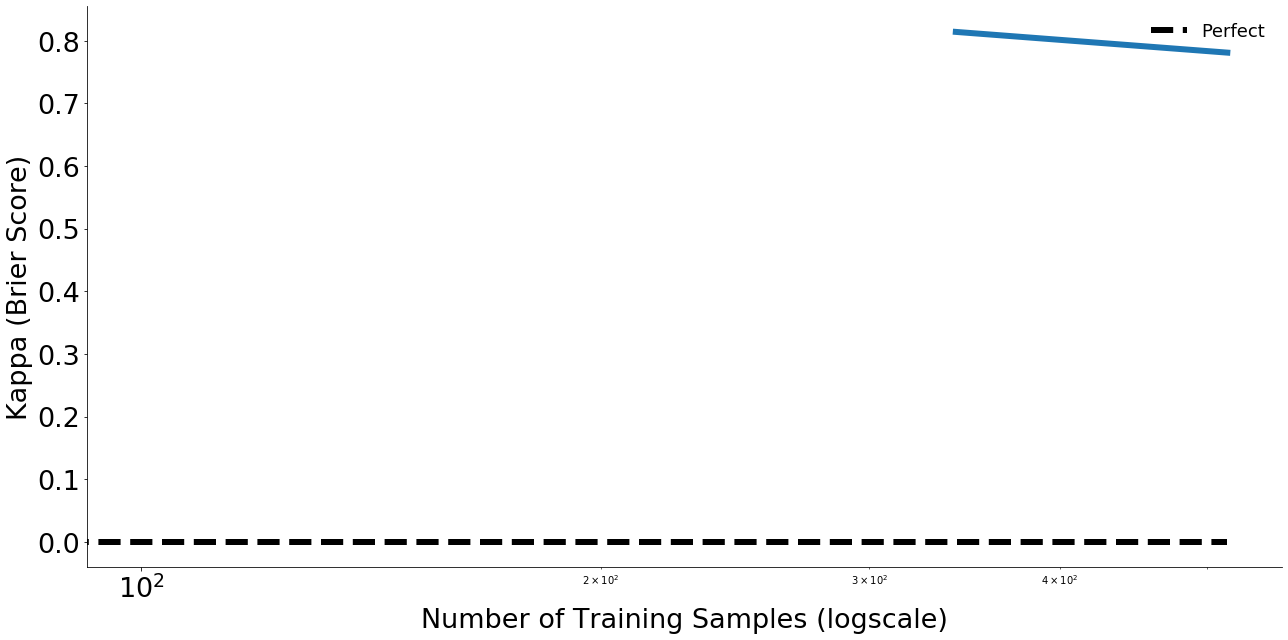

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater


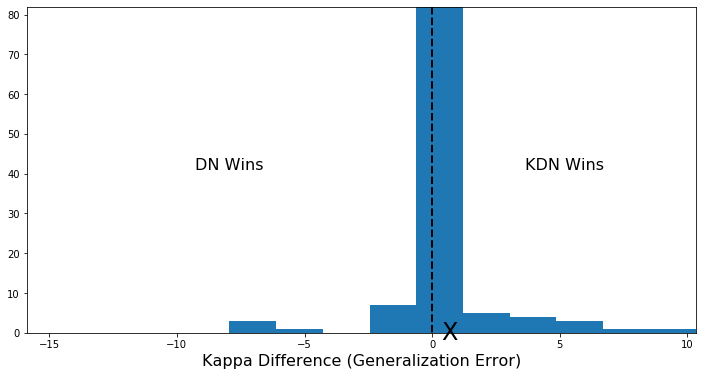

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


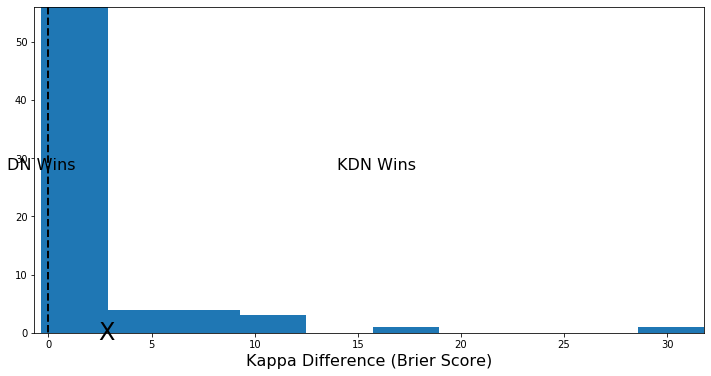

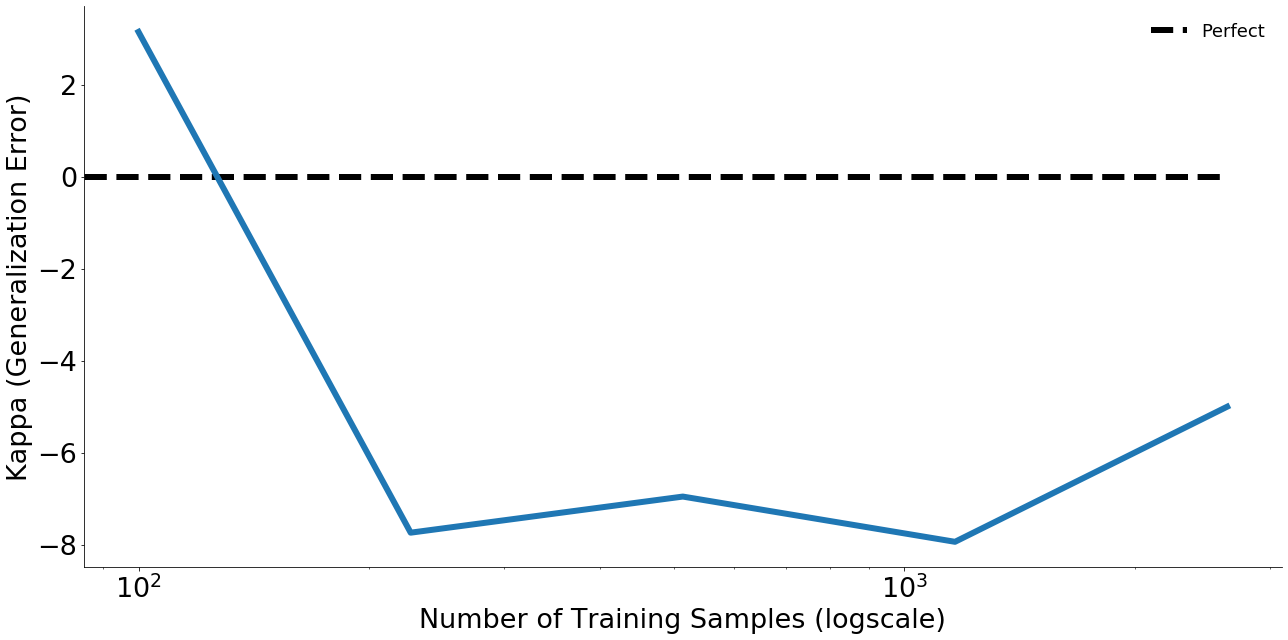

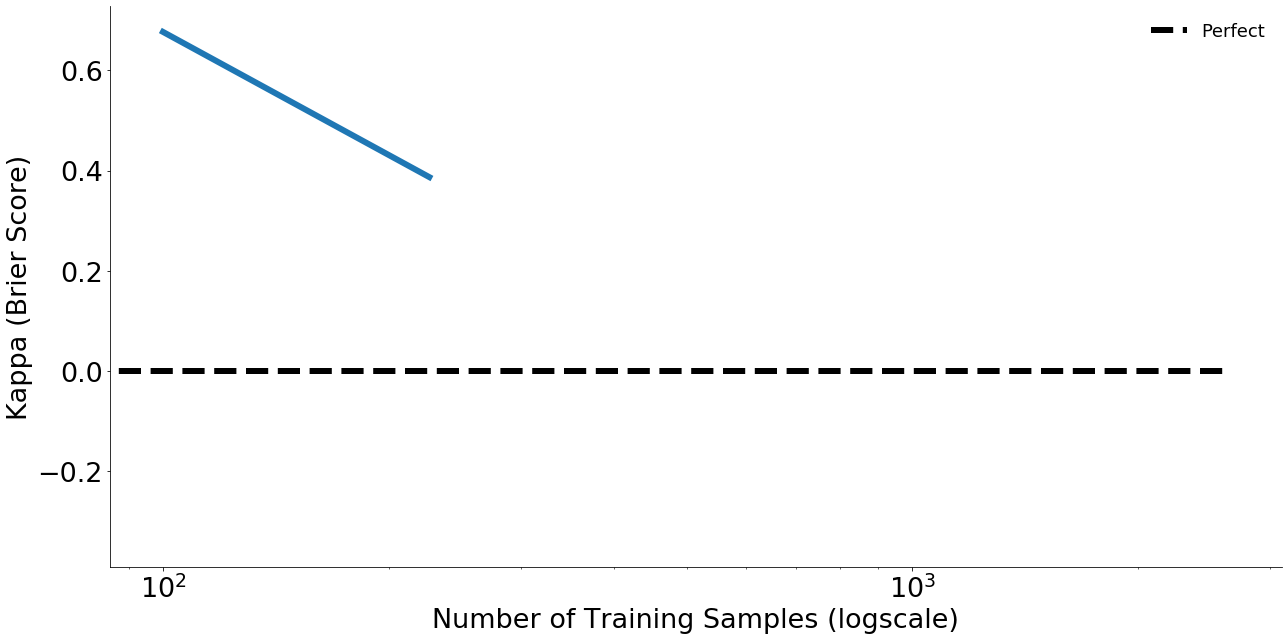

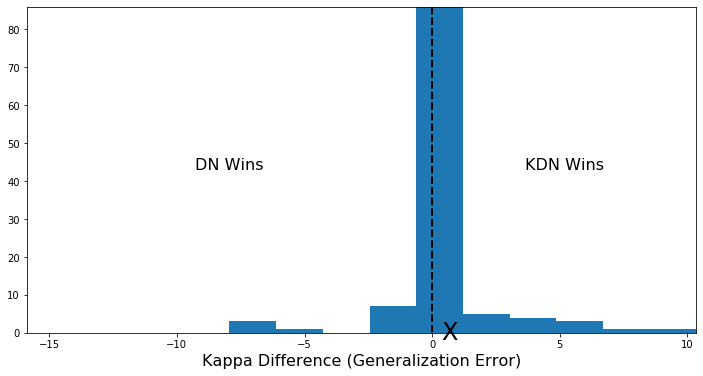

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


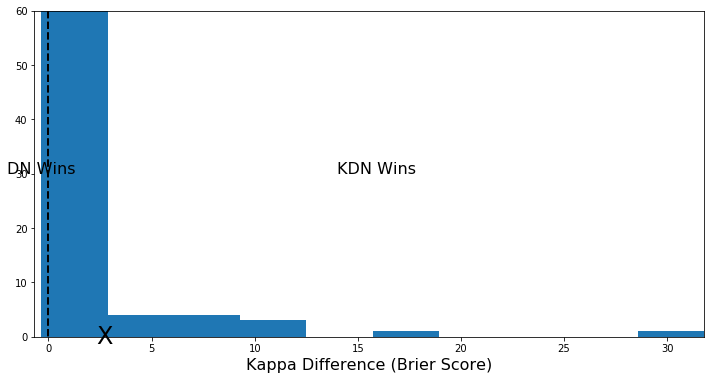

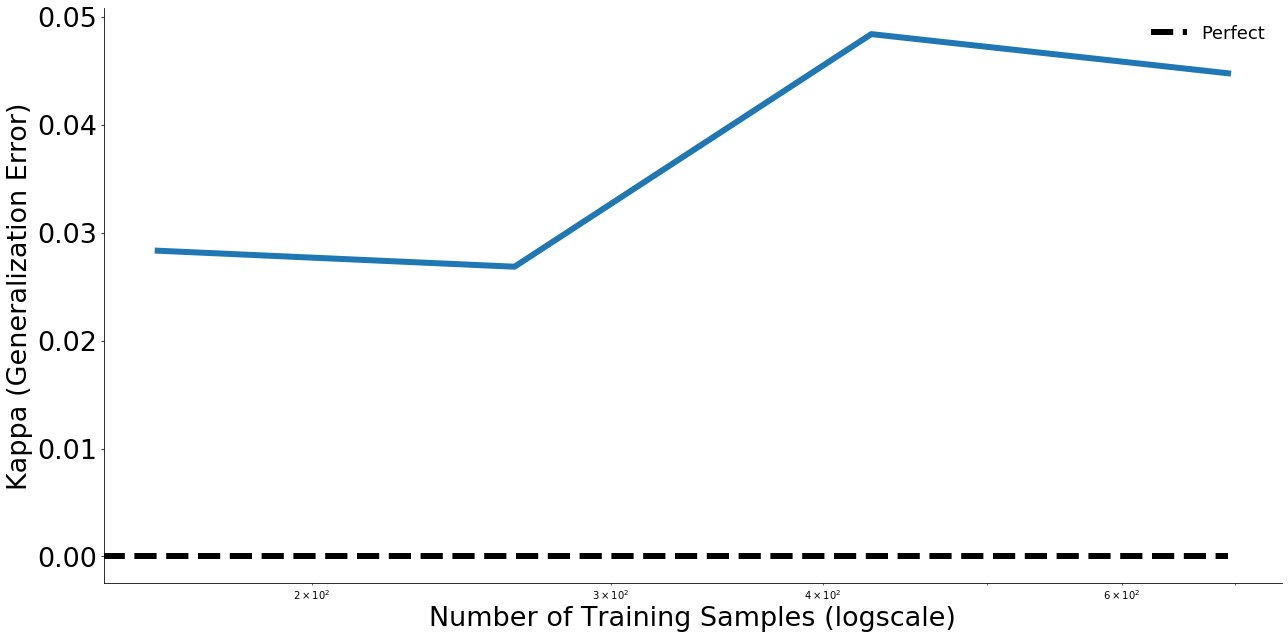

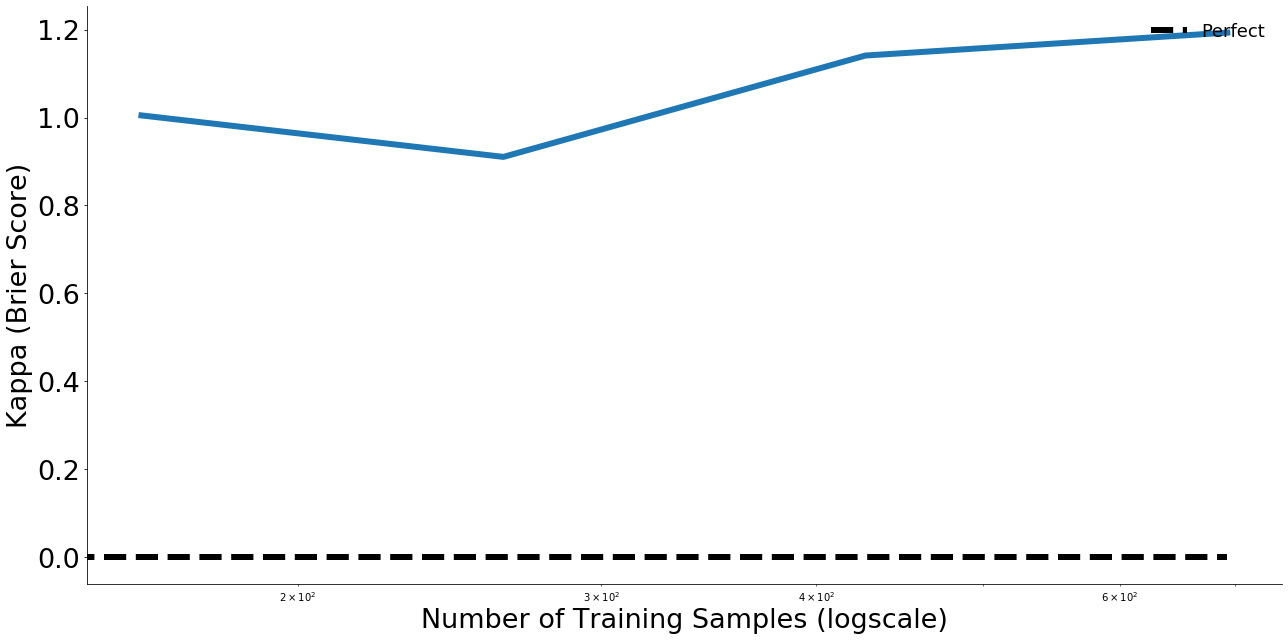

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


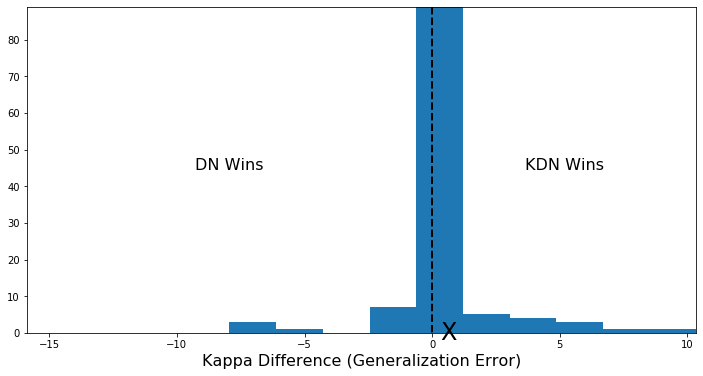

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


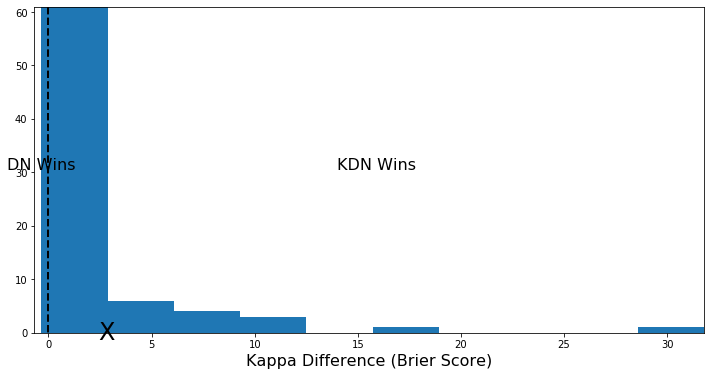

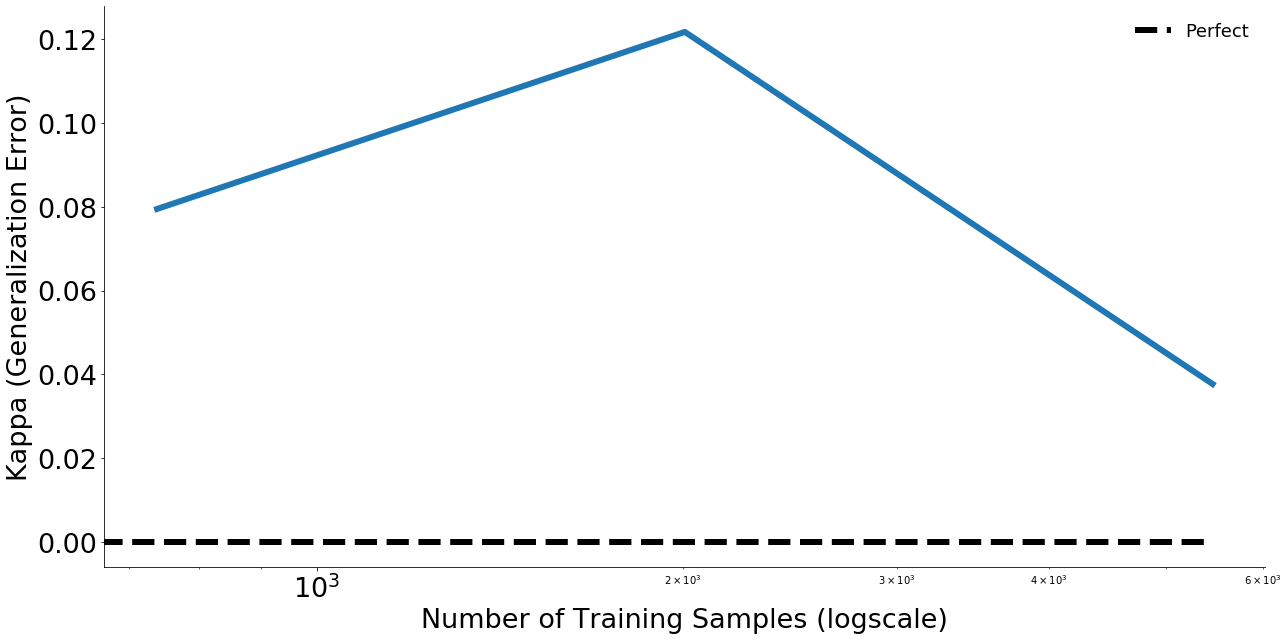

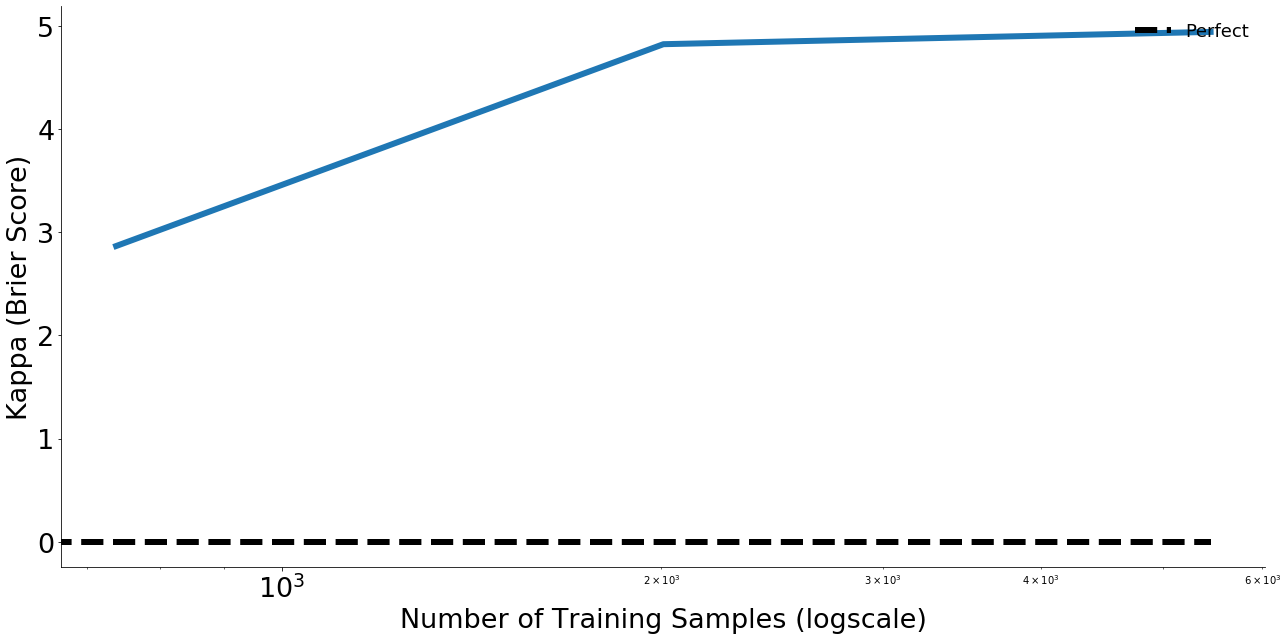

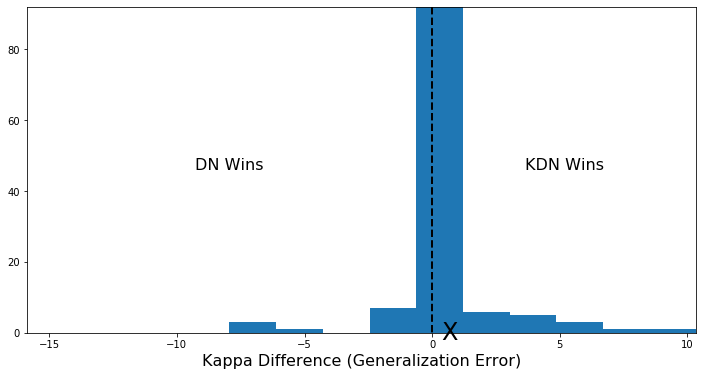

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


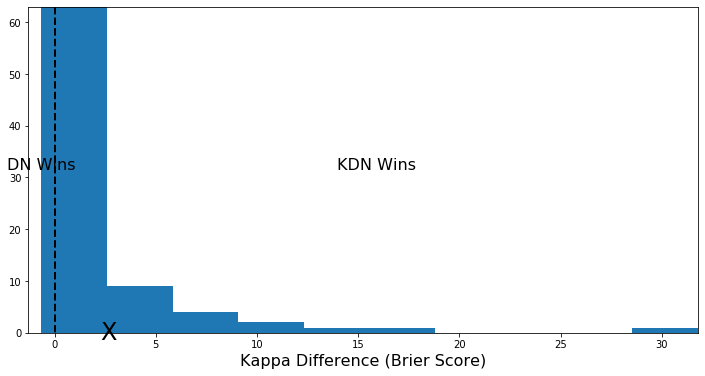

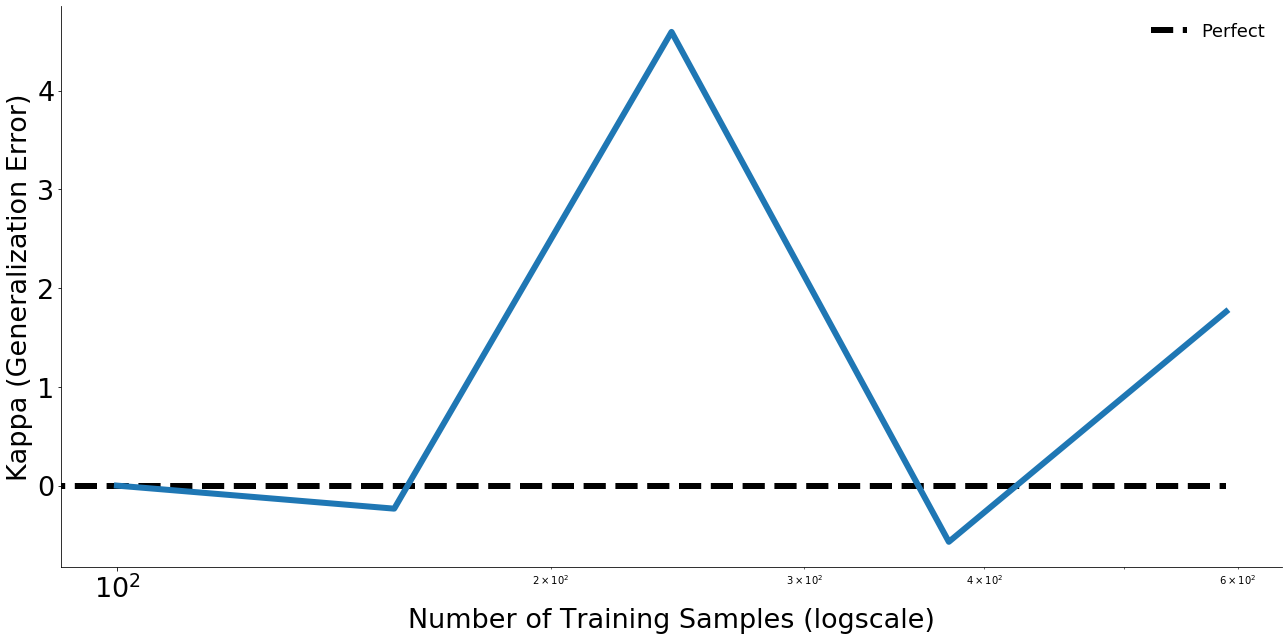

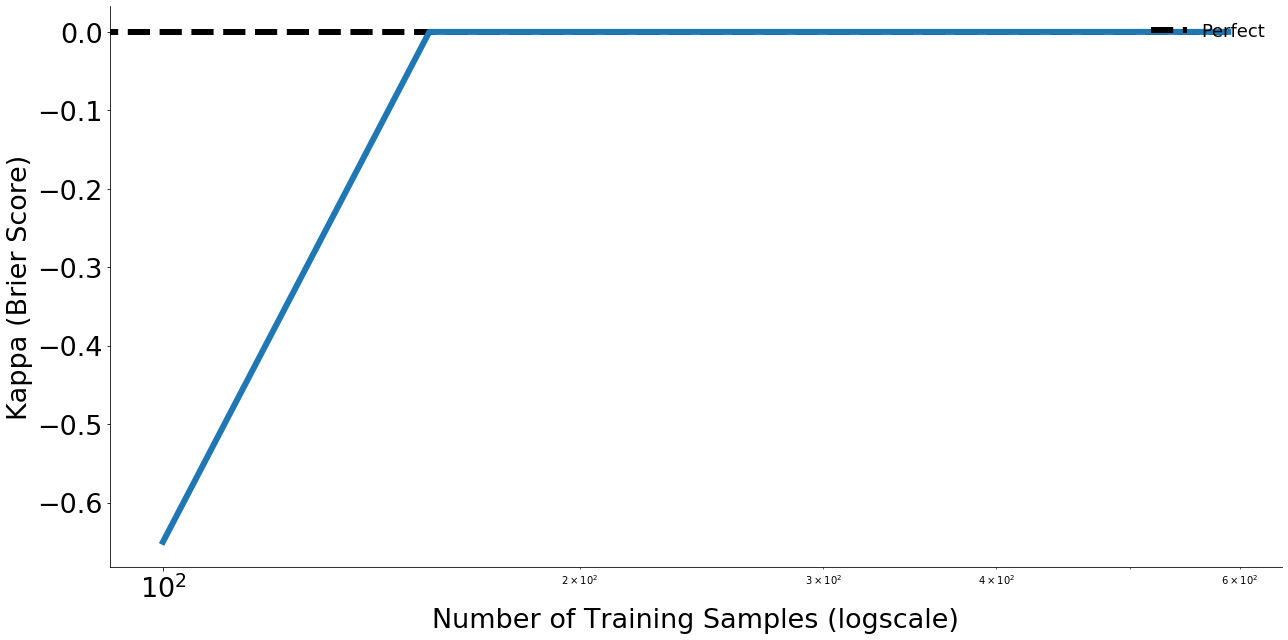

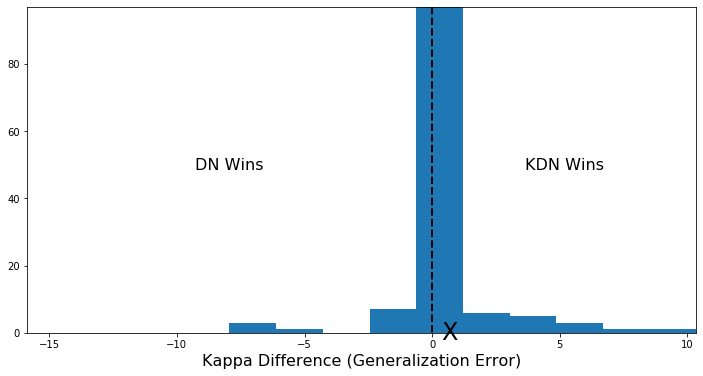

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in less


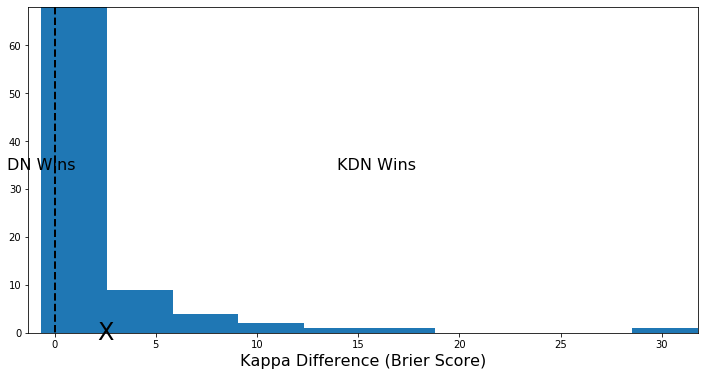

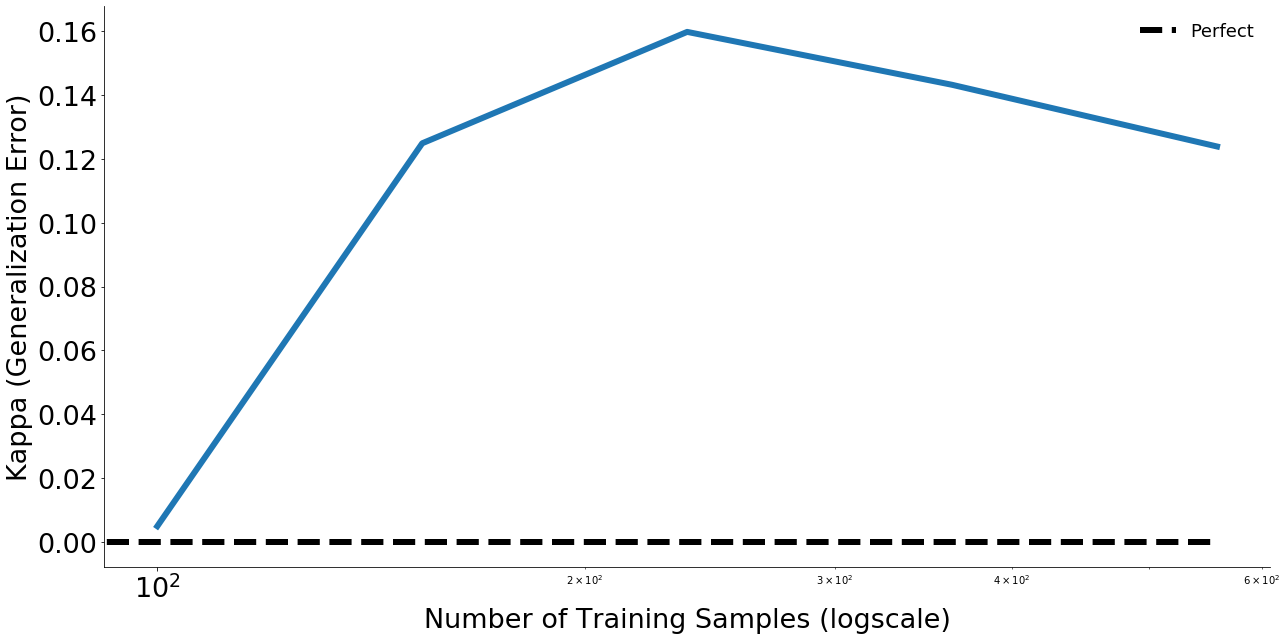

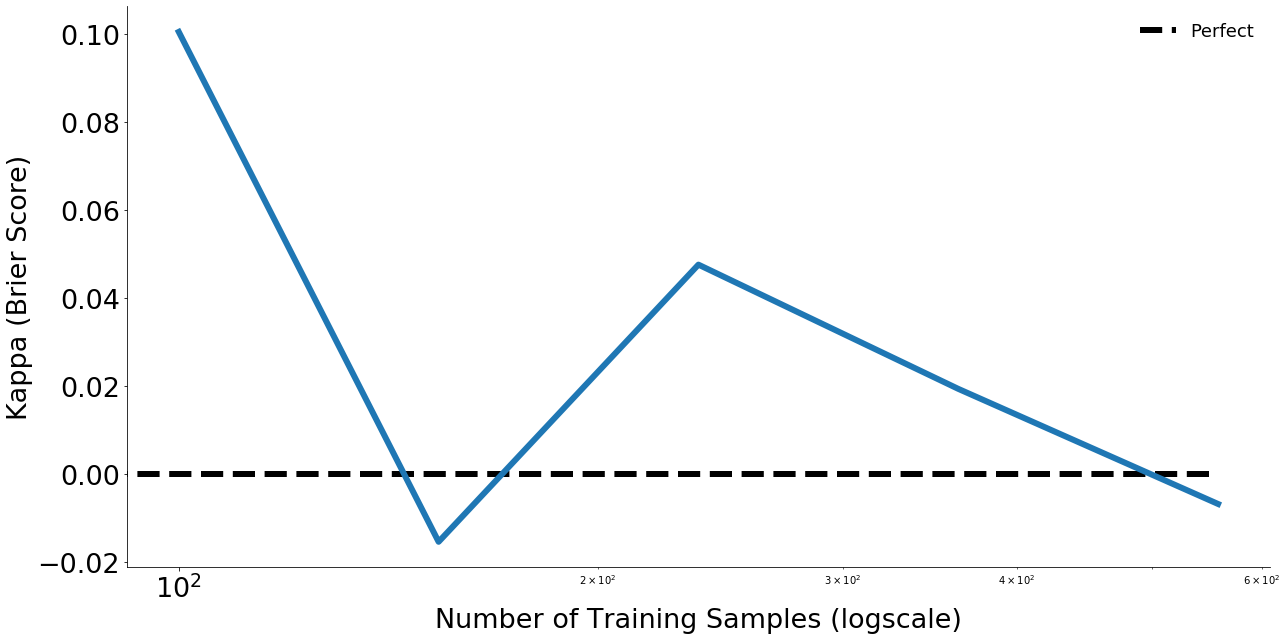

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


In [ ]:
kappa_acc_means = []
kappa_ece_means = []

kappa_acc_stds = []
kappa_ece_stds = []

ds = []
ns = []
traces_X = []
traces_y = []
num_classes = []
for task_id in tqdm(openml.study.get_suite("OpenML-CC18").tasks):
    try:
        successfully_loaded = True
        dataset = openml.datasets.get_dataset(openml.tasks.get_task(task_id).dataset_id)
        X, y, is_categorical, _ = dataset.get_data(
            dataset_format="array", target=dataset.default_target_attribute
        )
        _, y = np.unique(y, return_inverse = True)
        X = np.nan_to_num(X)
    except TypeError:
        print("Skipping Dataset {}".format(dataset_idx))
        print()
        successfully_loaded = False
        
    if successfully_loaded:
        try:
            len(X)
        except:
            X = X.toarray()
    
    if successfully_loaded and np.shape(X)[1] > 0:
        if len(X) > 100 / .7:
            n_ra = np.logspace(2, np.log10(len(X) * 0.7), num = 5, base = 10)
            kappa_acc_across_n = []
            kappa_ece_across_n = []
            ns_across_n = []
            ds_across_n = []
            for n in tqdm(n_ra):
                kappa_acc_across_trials = []
                kappa_ece_across_trials = []
                kfold = KFold(n_splits = num_trials)
                for train_idx, test_idx in kfold.split(X):
                    try:
                        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
                        unique_y_train = np.unique(y_train)
                        counts = np.bincount(y_test)
                        max_class_frequency = np.max(counts)
                        bayes_error = max_class_frequency / len(y_test)
                        bayes_ece = get_brier(np.array([(counts / np.sum(counts)) for _ in range(len(y_test))]), y_test)

                        KDE_y_proba = get_KDE_y_proba(X_train, y_train, n, X_test)
                        network_y_proba = get_network_y_proba(X_train, y_train, n, X_test)

                        KDE_acc = (bayes_error + 1e-12) / (np.nanmean(np.argmax(KDE_y_proba, axis = 1) != y_test) + 1e-12)
                        network_acc = (bayes_error + 1e-12) / (np.nanmean(np.argmax(network_y_proba, axis = 1) != y_test) + 1e-12)
                        kappa_acc_across_trials.append(KDE_acc - network_acc)
                        
                        KDE_ece = (bayes_ece + 1e-12) / (get_brier(KDE_y_proba, y_test) + 1e-12)
                        network_ece = (bayes_ece + 1e-12) / (get_brier(network_y_proba, y_test) + 1e-12)
                        kappa_ece_across_trials.append(KDE_ece - network_ece)
                    except:
                        pass
                if len(kappa_acc_across_trials) > 0:
                    kappa_acc_across_n.append(np.median(kappa_acc_across_trials))
                    kappa_ece_across_n.append(np.median(kappa_ece_across_trials))
                    ds_across_n.append(np.shape(X)[1])
                    ns_across_n.append(n)
            kappa_acc_means = np.concatenate([kappa_acc_means, kappa_acc_across_n], axis = 0)
            kappa_ece_means = np.concatenate([kappa_ece_means, kappa_ece_across_n], axis = 0)
            ns = np.concatenate([ns, ns_across_n])
            ds = np.concatenate([ds, ds_across_n])
                
            #GE
            figs, ax = plt.subplots(1, 1, figsize = (12, 6))
            finite_idxs = np.where(~np.isnan(kappa_acc_means) & (np.abs(kappa_acc_means) < 100))
            bins, vals = ax.hist(np.array(kappa_acc_means)[finite_idxs])[:2]
            ax.vlines(0, np.max(bins), 0, linewidth = 2, linestyle = "dashed")
            ax.text(np.min(vals), np.max(bins) / 2, "DN Wins", ha = "center", size = 16)
            ax.text(np.max(vals) / 2, np.max(bins) / 2, "KDN Wins", ha = "center", size = 16)
            ax.text(np.mean(np.array(kappa_acc_means)[finite_idxs]), 0, "X", size = 24, va = "center")
            ax.set_xlim(2*np.min(vals), np.max(vals))
            ax.set_ylim(0, np.max(bins))
            ax.set_xlabel("Kappa Difference (Generalization Error)", fontsize = 16)
            plt.show()


            #Brier 
            figs, ax = plt.subplots(1, 1, figsize = (12, 6))
            finite_idxs = np.where(~np.isnan(kappa_ece_means) & (np.abs(kappa_ece_means) < 100))
            bins, vals = ax.hist(np.array(kappa_ece_means)[finite_idxs])[:2]
            ax.vlines(0, np.max(bins), 0, linewidth = 2, linestyle = "dashed")
            ax.text(np.min(vals), np.max(bins) / 2, "DN Wins", ha = "center", size = 16)
            ax.text(np.max(vals) / 2, np.max(bins) / 2, "KDN Wins", ha = "center", size = 16)
            ax.text(np.mean(np.array(kappa_ece_means)[finite_idxs]), 0, "X", size = 24, va = "center")
            ax.set_xlim(2*np.min(vals), np.max(vals))
            ax.set_ylim(0, np.max(bins))
            ax.set_xlabel("Kappa Difference (Brier Score)", fontsize = 16)
            plt.show()

            if len(kappa_acc_means) > 1:
                figs, ax = plt.subplots(1, 1, figsize = (18, 9))
                figs.set_facecolor("white")

                ax.tick_params(axis='both', which='major', labelsize=27)
                ax.plot(ns_across_n, kappa_acc_across_n)
                ax.hlines(0.0, 0, np.max(ns_across_n), linestyle = "dashed", label = "Perfect", color = "black")
                ax.legend(fontsize = 18, loc = "upper right", frameon = False)
                ax.set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
                ax.set_ylabel("Kappa (Generalization Error)", fontsize = 27)
                ax.set_xscale("log")
                for side in {"right", "top"}:
                        ax.spines[side].set_visible(False)


                figs.tight_layout()

                plt.show()

            if len(kappa_ece_means) > 1:
                figs, ax = plt.subplots(1, 1, figsize = (18, 9))
                figs.set_facecolor("white")

                ax.tick_params(axis='both', which='major', labelsize=27)
                ax.plot(ns_across_n, kappa_ece_across_n)
                ax.hlines(0.0, 0, np.max(ns_across_n), linestyle = "dashed", label = "Perfect", color = "black")
                ax.legend(fontsize = 18, loc = "upper right", frameon = False)
                ax.set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
                ax.set_ylabel("Kappa (Brier Score)", fontsize = 27)
                ax.set_xscale("log")
                for side in {"right", "top"}:
                        ax.spines[side].set_visible(False)


                figs.tight_layout()

                plt.show()

            
        else:
            print("Skipping Dataset")
            print()

    



In [ ]:
#GE
figs, ax = plt.subplots(1, 1, figsize = (12, 6))
finite_idxs = np.where(~np.isnan(kappa_acc_means) & (np.abs(kappa_acc_means) < 100))
bins, vals = ax.hist(np.array(kappa_acc_means)[finite_idxs])[:2]
ax.vlines(0, np.max(bins), 0, linewidth = 2, linestyle = "dashed")
ax.text(np.min(vals), np.max(bins) / 2, "DN Wins", ha = "center", size = 16)
ax.text(np.max(vals) / 2, np.max(bins) / 2, "KDN Wins", ha = "center", size = 16)
ax.text(np.mean(np.array(kappa_acc_means)[finite_idxs]), 0, "X", size = 24, va = "center")
ax.set_xlim(2*np.min(vals), np.max(vals))
ax.set_ylim(0, np.max(bins))
ax.set_xlabel("Kappa Difference (Generalization Error)", fontsize = 16)
plt.show()


#Brier 
figs, ax = plt.subplots(1, 1, figsize = (12, 6))
finite_idxs = np.where(~np.isnan(kappa_ece_means) & (np.abs(kappa_ece_means) < 100))
bins, vals = ax.hist(np.array(kappa_ece_means)[finite_idxs])[:2]
ax.vlines(0, np.max(bins), 0, linewidth = 2, linestyle = "dashed")
ax.text(-5, np.max(bins) / 2, "DN Wins", ha = "center", size = 16)
ax.text(np.max(vals) / 2, np.max(bins) / 2, "KDN Wins", ha = "center", size = 16)
ax.text(np.mean(np.array(kappa_ece_means)[finite_idxs]), 0, "X", size = 24, va = "center")
ax.set_xlim(-10, np.max(vals))
ax.set_ylim(0, np.max(bins))
ax.set_xlabel("Kappa Difference (Brier Score)", fontsize = 16)
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (16, 16))
finite_idxs = np.where(~np.isnan(kappa_acc_means) & (np.abs(kappa_acc_means) < 100))

#Sample Size
axs[0][0].set_xscale('log')
sns.regplot(np.array(ns)[finite_idxs], np.array(kappa_acc_means)[finite_idxs], lowess = True, marker = ".", ax = axs[0][0], line_kws = {"color" : "red", "linewidth" : 2})
axs[0][0].set_xlabel("Sample Size", fontsize = 16)
axs[0][0].set_ylabel("Kappa Difference (Generalization Error)", fontsize = 16)
axs[0][0].set_ylim(-0.5, 0.5)
axs[0][0].set_xlim(100, 10000)

#Dimensionality
axs[0][1].set_xscale('log')
sns.regplot(np.array(ds)[finite_idxs], np.array(kappa_acc_means)[finite_idxs], lowess = True, marker = ".", ax = axs[0][1], line_kws = {"color" : "red", "linewidth" : 2})
axs[0][1].set_xlabel("Dimensinality", fontsize = 16)
axs[0][1].set_ylabel("Kappa Difference (Generalization Error)", fontsize = 16)
axs[0][1].set_ylim(-0.5, 1)
axs[0][1].set_xlim(5, 1000)

finite_idxs = np.where(~np.isnan(kappa_ece_means) & (np.abs(kappa_ece_means) < 100))

#Sample Size
axs[1][0].set_xscale('log')
sns.regplot(np.array(ns)[finite_idxs], np.array(kappa_ece_means)[finite_idxs], lowess = True, marker = ".", ax = axs[1][0], line_kws = {"color" : "red", "linewidth" : 2})
axs[1][0].set_xlabel("Sample Size", fontsize = 16)
axs[1][0].set_ylabel("Kappa Difference (Brier Score)", fontsize = 16)
axs[1][0].set_ylim(0, 2)
axs[1][0].set_xlim(100, 10000)

#Dimensionality
#Sample Size
axs[1][1].set_xscale('log')
sns.regplot(np.array(ds)[finite_idxs], np.array(kappa_ece_means)[finite_idxs], lowess = True, marker = ".", ax = axs[1][1], line_kws = {"color" : "red", "linewidth" : 2})
axs[1][1].set_xlabel("Dimensinality", fontsize = 16)
axs[1][1].set_ylabel("Kappa Difference (Brier Score)", fontsize = 16)
axs[1][1].set_ylim(0, 5)
axs[1][1].set_xlim(5, 1000)